# **Import the Libraries**

In [1]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
 
%matplotlib inline
 
from sklearn.model_selection import train_test_split


from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU,SimpleRNN, Dense, Dropout, Flatten, Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.applications.vgg16 import preprocess_input
 
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# **Download and Visualize the Data with its Labels**

UCF101 is an action recognition data set
*   having 101 action categories
*   with 13320 videos from 101 action categories.
*   25 Groups of Videos per Action Category
*   All clips have fixed
frame rate and resolution of 25 FPS and 320 × 240 respectively




In [2]:
# Define the path to the UCF-101 dataset
ucf_path = "/kaggle/input/ucf-modified/UCF-21-modified"

For visualization, we will pick all categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written. This way we’ll be able to visualize a subset ( 32 random videos ) of the dataset.

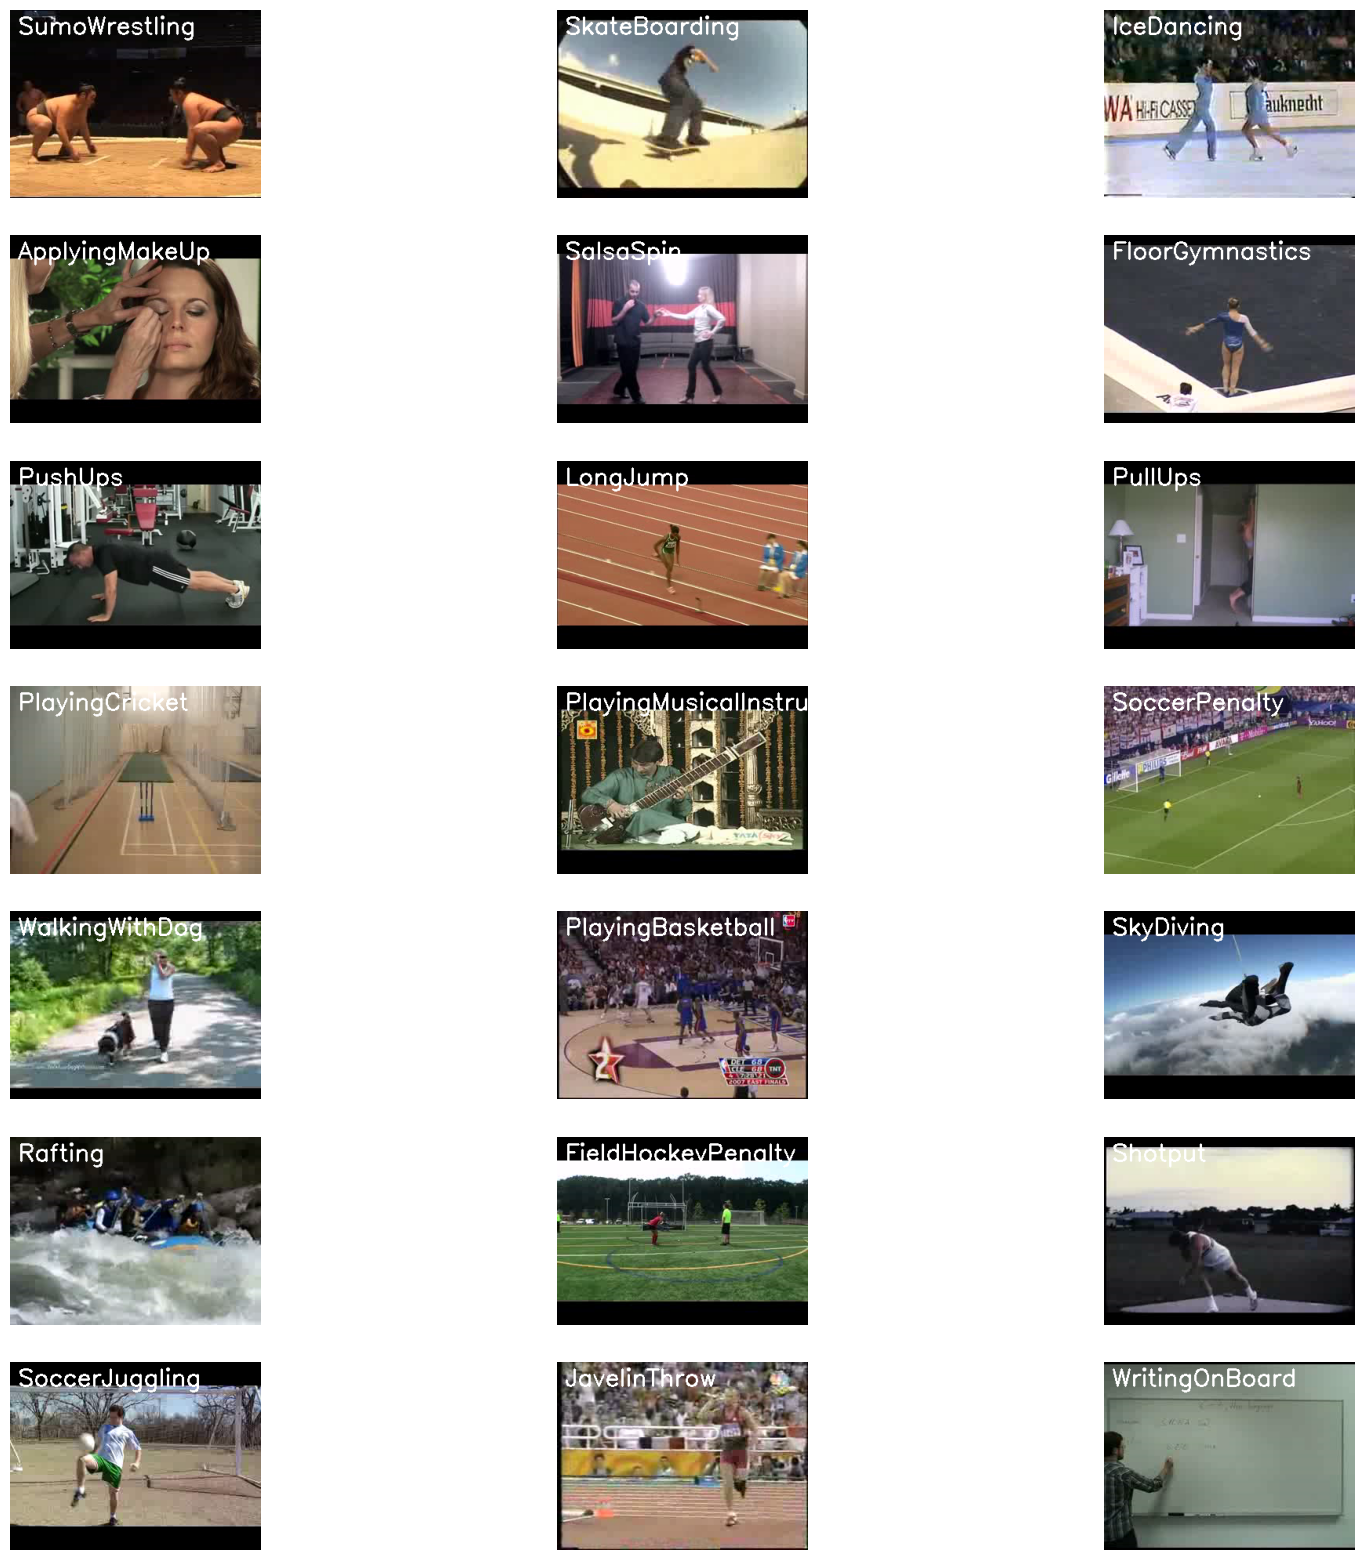

In [6]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))
 
# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir(ucf_path)
 
# Generate a list of 20 random values. The values will be between 0-21, 
# where 21 is the total number of classes being in the dataset. 
#random_range = random.sample(range(len(all_classes_names)), 20)
tot_classes = range(len(all_classes_names))
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(tot_classes, 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'{ucf_path}/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'{ucf_path}/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
 
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(7, 3, counter);plt.imshow(rgb_frame);plt.axis('off')

In [7]:
CLASSES_LIST =os.listdir(ucf_path)
CLASSES_LIST

['SumoWrestling',
 'SkateBoarding',
 'IceDancing',
 'ApplyingMakeUp',
 'SalsaSpin',
 'FloorGymnastics',
 'PushUps',
 'LongJump',
 'PullUps',
 'PlayingCricket',
 'PlayingMusicalInstrument',
 'SoccerPenalty',
 'WalkingWithDog',
 'PlayingBasketball',
 'SkyDiving',
 'Rafting',
 'FieldHockeyPenalty',
 'Shotput',
 'SoccerJuggling',
 'JavelinThrow',
 'WritingOnBoard']

# **Video Paths and One-hot Labels**

In [3]:
# Path to the UCF-21 dataset directory
ucf_dir = "/kaggle/input/ucf-modified/UCF-21-modified"

# Get list of subdirectories (i.e., action categories) within the UCF-21 directory
subdirs = [os.path.join(ucf_dir, d) for d in os.listdir(ucf_dir) if os.path.isdir(os.path.join(ucf_dir, d))]

# Initialize empty lists for video paths and labels
video_paths = []
labels = []

# Loop through each subdirectory and get list of video file names
for class_idx, subdir in enumerate((subdirs)):
    videos = [os.path.join(subdir, f) for f in os.listdir(subdir) if os.path.isfile(os.path.join(subdir, f))]

    # Append video paths and corresponding label index to the respective lists
    video_paths.extend(videos)
    labels.extend([class_idx] * len(videos))

In [4]:
# Print the first 10 entries in each list for verification
print(video_paths[4150:4161])
print(labels[4100:])

['/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g01_c03.avi', '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g24_c03.avi', '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g16_c06.avi', '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g18_c01.avi', '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g23_c06.avi', '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g12_c01.avi', '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g19_c01.avi', '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g10_c03.avi', '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g18_c02.avi', '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g12_c04.avi', '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g03_c06.avi']
[19, 19, 

In [6]:
len(video_paths)

4267

In [7]:
len(labels)

4267

In [5]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [9]:
one_hot_encoded_labels.shape

(4267, 21)

# **Train-Test Split 01**

In [6]:
# Open the file in read mode
file = open('/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/trainlist01.txt', 'r')
# Read the contents of the file
contents = file.read()
# Close the file
file.close()

list1 = contents.split("\n") #converting the text file to a list

extract_str1 = lambda s: s.split('/')[-1]
# Create a new array with the extracted portion of the file path name
temp1 = [extract_str1(path) for path in list1]

extract_str2 = lambda s: s.split(' ')[0]
train_list1 = [extract_str2(path) for path in temp1]

In [7]:
# In this example, we'll extract everything after the last "/"
extract_str1 = lambda s: s.split('/')[-1]

train_indices_1= []

for idx,path in enumerate(video_paths):
    for j in range(len(train_list1)):
        if extract_str1(path) == train_list1[j]:
            train_indices_1.append(idx)

In [12]:
len(train_indices_1)

3035

In [8]:
test_indices_1 = [i for i in range(len(video_paths)) if i not in train_indices_1]

In [14]:
len(test_indices_1)

1232

In [9]:
train_video_paths_1 = [video_paths[i] for i in train_indices_1]

In [10]:
train_labels_1 = [one_hot_encoded_labels[i] for i in train_indices_1]

In [11]:
test_video_paths_1 = [video_paths[i] for i in test_indices_1]

In [12]:
test_labels_1 = [one_hot_encoded_labels[i] for i in test_indices_1]

# **Train-Test Split 02**

In [44]:
# Open the file in read mode
file = open('/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/trainlist02.txt', 'r')
# Read the contents of the file
contents = file.read()
# Close the file
file.close()

list2 = contents.split("\n") #converting the text file to a list

extract_str1 = lambda s: s.split('/')[-1]
# Create a new array with the extracted portion of the file path name
temp2 = [extract_str1(path) for path in list2]

extract_str2 = lambda s: s.split(' ')[0]
train_list2 = [extract_str2(path) for path in temp2]

In [45]:
# In this example, we'll extract everything after the last "/"
extract_str1 = lambda s: s.split('/')[-1]

train_indices_2= []

for idx,path in enumerate(video_paths):
    for j in range(len(train_list2)):
        if extract_str1(path) == train_list2[j]:
            train_indices_2.append(idx)

In [46]:
len(train_indices_2)

3064

In [47]:
test_indices_2 = [i for i in range(len(video_paths)) if i not in train_indices_2]

In [48]:
len(test_indices_2)

1203

In [50]:
train_video_paths_2 = [video_paths[i] for i in train_indices_2]

In [52]:
train_labels_2 = [one_hot_encoded_labels[i] for i in train_indices_2]

In [53]:
test_video_paths_2 = [video_paths[i] for i in test_indices_2]

In [55]:
test_labels_2 = [one_hot_encoded_labels[i] for i in test_indices_2]

# **Train-Test Split 03**

In [56]:
# Open the file in read mode
file = open('/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/trainlist03.txt', 'r')
# Read the contents of the file
contents = file.read()
# Close the file
file.close()

list3 = contents.split("\n") #converting the text file to a list

extract_str1 = lambda s: s.split('/')[-1]
# Create a new array with the extracted portion of the file path name
temp3 = [extract_str1(path) for path in list3]

extract_str2 = lambda s: s.split(' ')[0]
train_list3 = [extract_str2(path) for path in temp3]

In [57]:
# In this example, we'll extract everything after the last "/"
extract_str1 = lambda s: s.split('/')[-1]

train_indices_3= []

for idx,path in enumerate(video_paths):
    for j in range(len(train_list3)):
        if extract_str1(path) == train_list3[j]:
            train_indices_3.append(idx)

In [58]:
len(train_indices_3)

3062

In [59]:
test_indices_3 = [i for i in range(len(video_paths)) if i not in train_indices_3]

In [60]:
len(test_indices_3)

1205

In [61]:
train_video_paths_3 = [video_paths[i] for i in train_indices_3]

In [62]:
train_labels_3 = [one_hot_encoded_labels[i] for i in train_indices_3]

In [63]:
test_video_paths_3 = [video_paths[i] for i in test_indices_3]

In [64]:
test_labels_3 = [one_hot_encoded_labels[i] for i in test_indices_3]

# **Image Specifications**

In [13]:
#Image Specifications
batch_size = 8
num_classes = 21
num_frames = 24
frame_size = (224,224)

# **Data Loader**

In [23]:
def video_data_generator(video_paths, labels, batch_size, num_classes, num_frames, frame_size):
    while True:
        # Shuffle the video paths and labels
        indices = np.arange(len(video_paths))
        np.random.shuffle(indices)
        video_paths = [video_paths[i] for i in indices]
        labels = [labels[i] for i in indices]

        folder_path = "/kaggle/input/ucf-modified/UCF-21-modified"

        # Loop through the video paths in batches
        for i in range(0, len(video_paths), batch_size):
            #print("\n", i)
            # Load the video frames and resize them to frame_size
            video_batch = []
            
            for path in video_paths[i:i+batch_size]:
                video_path = os.path.join(folder_path, path)
                video_frames = []
                #video_features = []
                video_capture = cv2.VideoCapture(video_path)
                num_frames_video = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
                step = num_frames_video // num_frames
                
                for j in range(num_frames_video):
                    ret, frame = video_capture.read()
                    if not ret:
                        break
                    if (j % step == 0) and (len(video_frames) < num_frames):
                                #print("\n", j)
                                #print("\nBefore resizing: ",frame)
                                frame_resized = cv2.resize(frame, frame_size)              # resizing frames
                                #print("\nAfter resizing", frames_resized)
                                #print("\nFrame shape is: ",frame_resized.shape)
                                #features_frame = vgg.predict(frame_resized)
                                video_frames.append(frame_resized)                             # this array is for for storing all frames of particular video
                                #video_features = np.vstack((video_features, features_frame))
                                #print("\nvideo features shape is: ",video_features.shape)
                video_capture.release()
                
                while len(video_frames) < num_frames:                                          # here i am verifying,if required no. of frames are extracted or not,
                    video_frames.append(np.zeros((224,224,3)))                                 #  if not, i am appending zero matrix of same shape to manage the corret shape

                if (np.array(video_frames)).shape != (num_frames, 224, 224, 3):                        # if video frames array is not of required shape,i will not process this batch
                     break
                
                video_frames = np.array(video_frames)
                #video_features = np.array(video_features)
                # Preprocess the frames using VGG16 preprocess_input function
                #video_frames = preprocess_input(video_frames)
                # Extract features using VGG16 model
                #print("\nVideo_frames has size: ", video_frames.shape)
                #video_features = cnn.predict(video_frames, verbose=0)                         # instead of predicting features for each single frame of the video, i am predicting for for all frames of the video at once
                #print("\nVideo_features has size: ", video_features.shape)
                #video_features_reshaped = video_features.reshape(num_frames,7*7*512)          # here i am flattening the features so that we can give it to lstm model
                video_batch.append(video_frames)                                   # here i am appending the video to thebatch array
            labels_batch = np.array(labels[i:i+batch_size])
            video_batch = np.array(video_batch)
            #print("\nVideo_batch shape is: ", video_batch.shape)
            #print("\nlabels_batch shape is: ", labels_batch.shape)
            
            # Yield the data batch
            yield video_batch, labels_batch

In [24]:
# Train the model using the video data generator function
train_gen_0 = video_data_generator(train_video_paths_1, train_labels_1, batch_size, num_classes, num_frames, frame_size)
val_gen_0 = video_data_generator(test_video_paths_1, test_labels_1, batch_size, num_classes, num_frames, frame_size)

**Model-1: (3DConv + LSTM)**

In [26]:
# Define the LSTM model to classify the video sequence based on extracted features
lstm1 = Sequential()
#lstm.add(Flatten(input_shape=(24*7*7*512, )))
lstm1.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(num_frames, 224,224,3)))
lstm1.add(MaxPooling3D(pool_size=(2, 2, 2)))
lstm1.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))
lstm1.add(MaxPooling3D(pool_size=(2, 2, 2)))
lstm1.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu'))
lstm1.add(MaxPooling3D(pool_size=(2, 2, 2)))

lstm1.add(Reshape((1, 26*26*128)))

lstm1.add(LSTM(512, input_shape=( 1,26*26*128), return_sequences=True))
#lstm.add(Dropout(0.5))
#lstm.add(LSTM(32, return_sequences=True))
#lstm.add(LSTM(32, return_sequences=True))
lstm1.add(Flatten())
#lstm.add(Dense(256, activation='relu'))
#lstm.add(Dense(32, activation='relu'))
#lstm.add(Dropout(0.5))
lstm1.add(Dense(num_classes, activation='softmax'))

lstm1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 22, 222, 222, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 11, 111, 111, 32)  0        
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 109, 109, 64)   55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 54, 54, 64)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 2, 52, 52, 128)    221312    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 26, 26, 128)   0

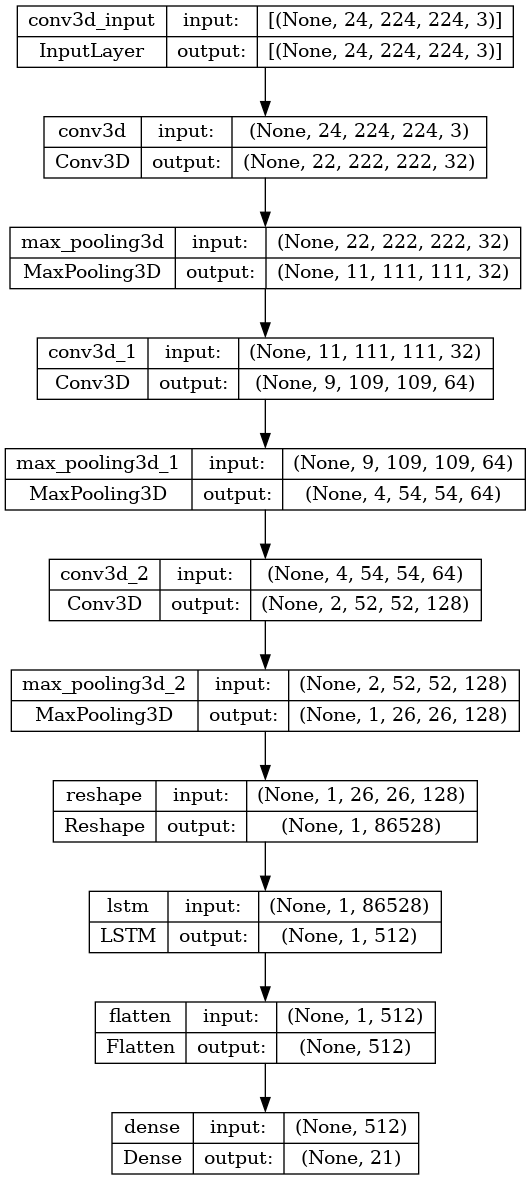

In [41]:
# Plot the structure of the contructed model.
plot_model(lstm1, show_shapes = True, show_layer_names = True)

In [27]:
# Compile the LSTM model
lstm1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


fit0a = lstm1.fit(train_gen_0, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=5, validation_data=val_gen_0, validation_steps=len(test_video_paths_1)//batch_size)

Epoch 1/5
379/379 [==============================] - 404s 1s/step - loss: 2.7239 - accuracy: 0.2978 - val_loss: 2.7435 - val_accuracy: 0.2963
Epoch 2/5
379/379 [==============================] - 306s 806ms/step - loss: 2.7097 - accuracy: 0.3003 - val_loss: 2.7397 - val_accuracy: 0.2955
Epoch 3/5
379/379 [==============================] - 307s 810ms/step - loss: 2.7123 - accuracy: 0.2990 - val_loss: 2.7353 - val_accuracy: 0.2971
Epoch 4/5
379/379 [==============================] - 298s 788ms/step - loss: 2.7121 - accuracy: 0.3006 - val_loss: 2.7405 - val_accuracy: 0.2979
Epoch 5/5
379/379 [==============================] - 298s 786ms/step - loss: 2.7155 - accuracy: 0.3003 - val_loss: 2.6934 - val_accuracy: 0.2930


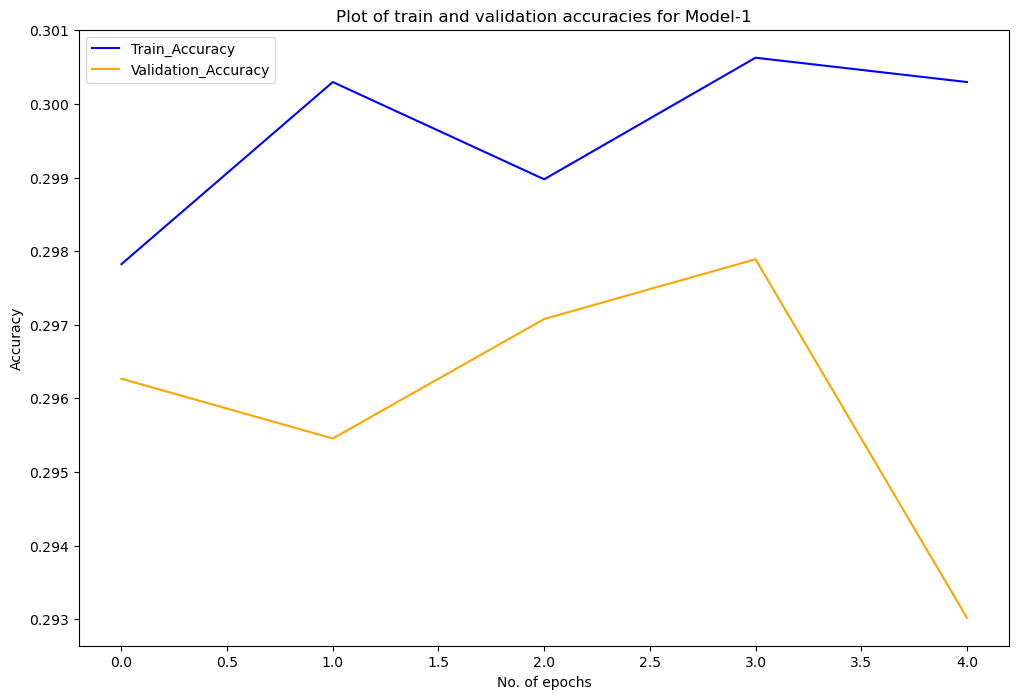

In [28]:
#plotting the training and validation accuracy vs epochs of Model-1
plt.figure(figsize = (12,8))
plt.plot(fit0a.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit0a.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-1")
plt.legend()
plt.show()

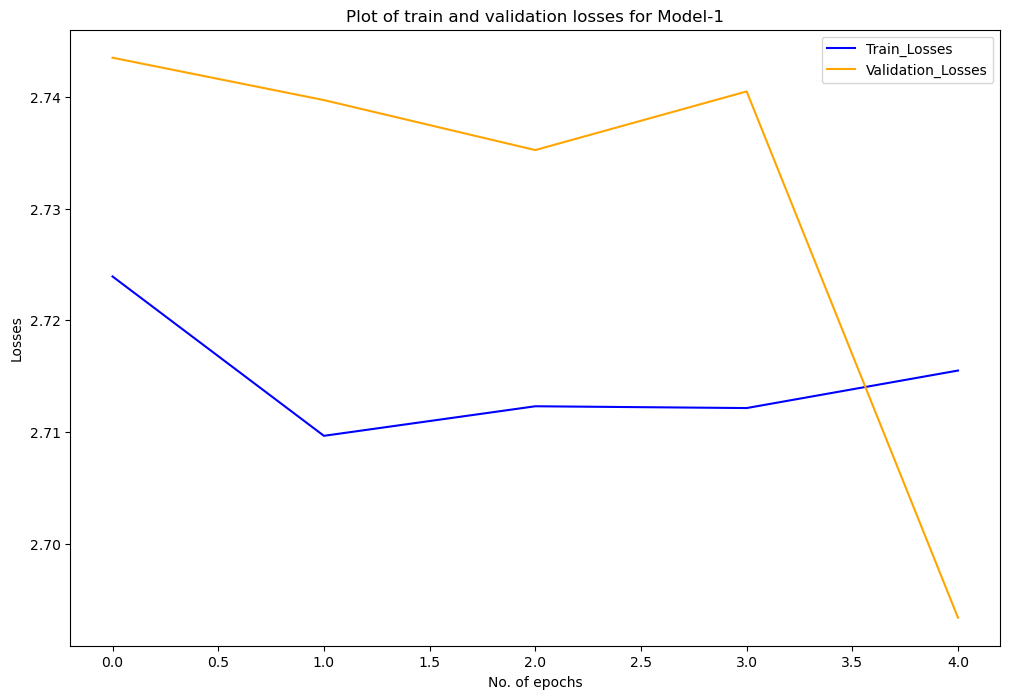

In [29]:
#plotting the training and validation losses vs epochs of Model-1
plt.figure(figsize = (12,8))
plt.plot(fit0a.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit0a.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-1")
plt.legend()
plt.show()

**Model-2: ConvLSTM**

In [32]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (24, 224,224,3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))    #a regularization technique
                                                #we are using dropout along with time distributed layer as we want the dropout to happen across each timestep
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))   #we are using max pooling 3D as we are working with a sequence of images
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(num_classes, activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

In [33]:
# Construct the required convlstm model.
convlstm_model1 = create_convlstm_model()

# Display the success message. 
print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_4 (ConvLSTM2D)  (None, 24, 222, 222, 4)   1024      
                                                                 
 max_pooling3d_7 (MaxPooling  (None, 24, 111, 111, 4)  0         
 3D)                                                             
                                                                 
 time_distributed_3 (TimeDis  (None, 24, 111, 111, 4)  0         
 tributed)                                                       
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 24, 109, 109, 8)   3488      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 24, 55, 55, 8)    0         
 3D)                                                             
                                                      

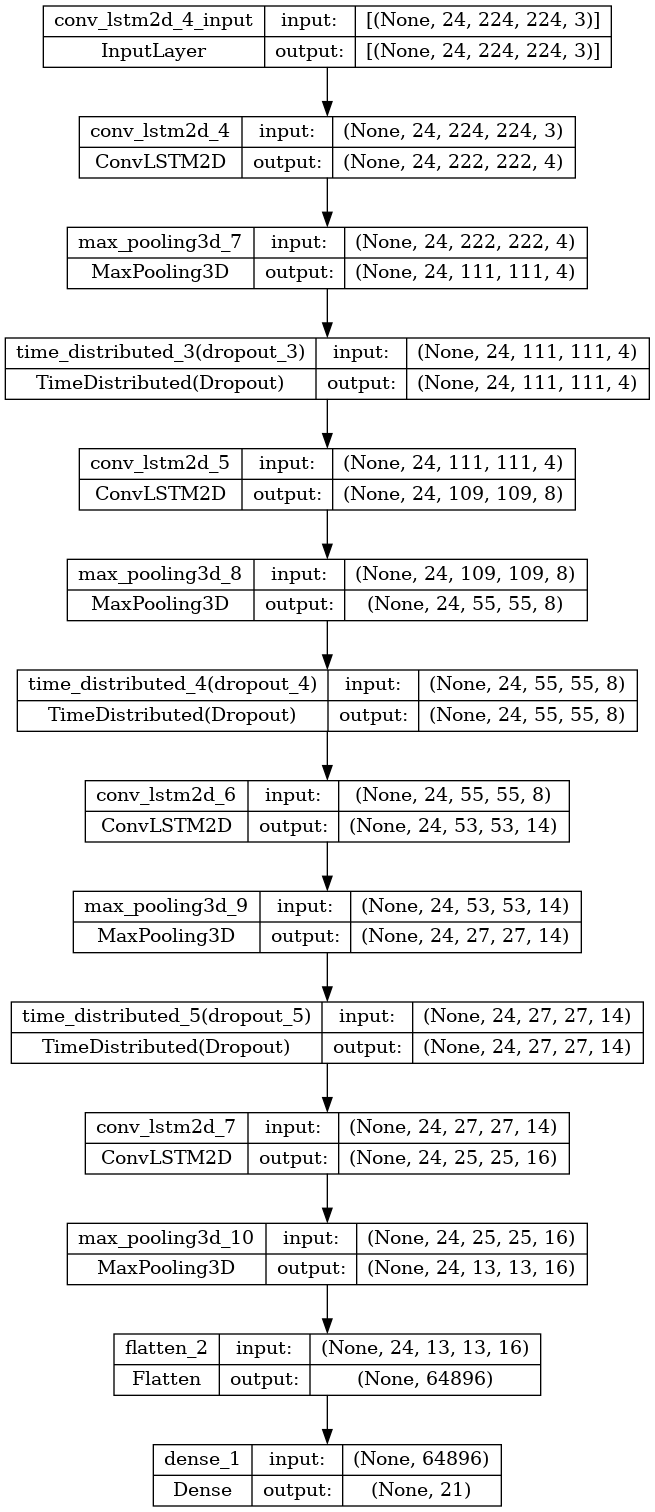

In [40]:
# Plot the structure of the contructed model.
plot_model(convlstm_model1, show_shapes = True, show_layer_names = True)

In [39]:
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model1.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
fit0b = convlstm_model1.fit(train_gen_0, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=5, validation_data=val_gen_0, validation_steps=len(test_video_paths_1)//batch_size)

Epoch 1/5


2023-04-24 12:05:19.403287: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/conv_lstm2d_4/while/body/_1/sequential_2/conv_lstm2d_4/while/dropout_3/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


379/379 [==============================] - 673s 2s/step - loss: 1.6859 - accuracy: 0.5084 - val_loss: 1.9033 - val_accuracy: 0.4846
Epoch 2/5
379/379 [==============================] - 661s 2s/step - loss: 0.8503 - accuracy: 0.7393 - val_loss: 2.4403 - val_accuracy: 0.4456
Epoch 3/5
379/379 [==============================] - 712s 2s/step - loss: 0.4558 - accuracy: 0.8586 - val_loss: 2.9618 - val_accuracy: 0.4529
Epoch 4/5
379/379 [==============================] - 716s 2s/step - loss: 0.2468 - accuracy: 0.9210 - val_loss: 3.3078 - val_accuracy: 0.4619
Epoch 5/5
379/379 [==============================] - 653s 2s/step - loss: 0.1708 - accuracy: 0.9432 - val_loss: 3.8123 - val_accuracy: 0.4529


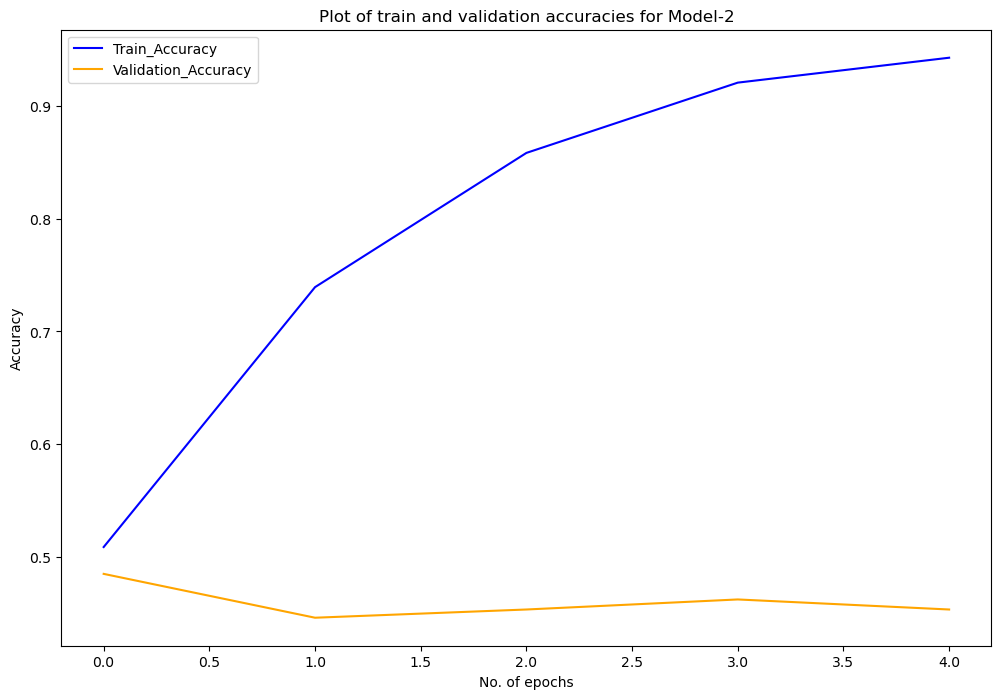

In [42]:
#plotting the training and validation accuracy vs epochs of Model-2
plt.figure(figsize = (12,8))
plt.plot(fit0b.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit0b.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-2")
plt.legend()
plt.show()

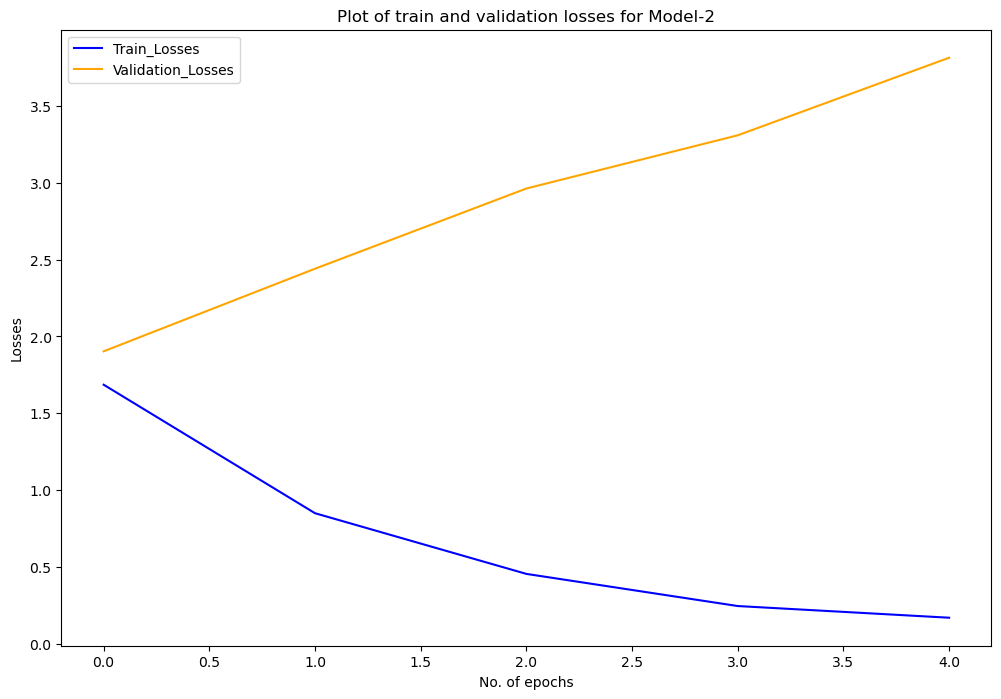

In [43]:
#plotting the training and validation losses vs epochs of Model-2
plt.figure(figsize = (12,8))
plt.plot(fit0b.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit0b.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-2")
plt.legend()
plt.show()

**Model-3 : (2DConv + LSTM)**

In [44]:
def create_LRCN_model(): 
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
 
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (24, 224,224,3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    #model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    #model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(num_classes, activation = 'softmax'))
 
    ########################################################################################################################
 
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [45]:
# Construct the required LRCN model.
LRCN_model1 = create_LRCN_model()
 
# Display the success message.
print("Model Created Successfully!")

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 24, 224, 224, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 24, 56, 56, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 24, 56, 56, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 24, 14, 14, 32)   0         
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 24, 14, 14, 64)  

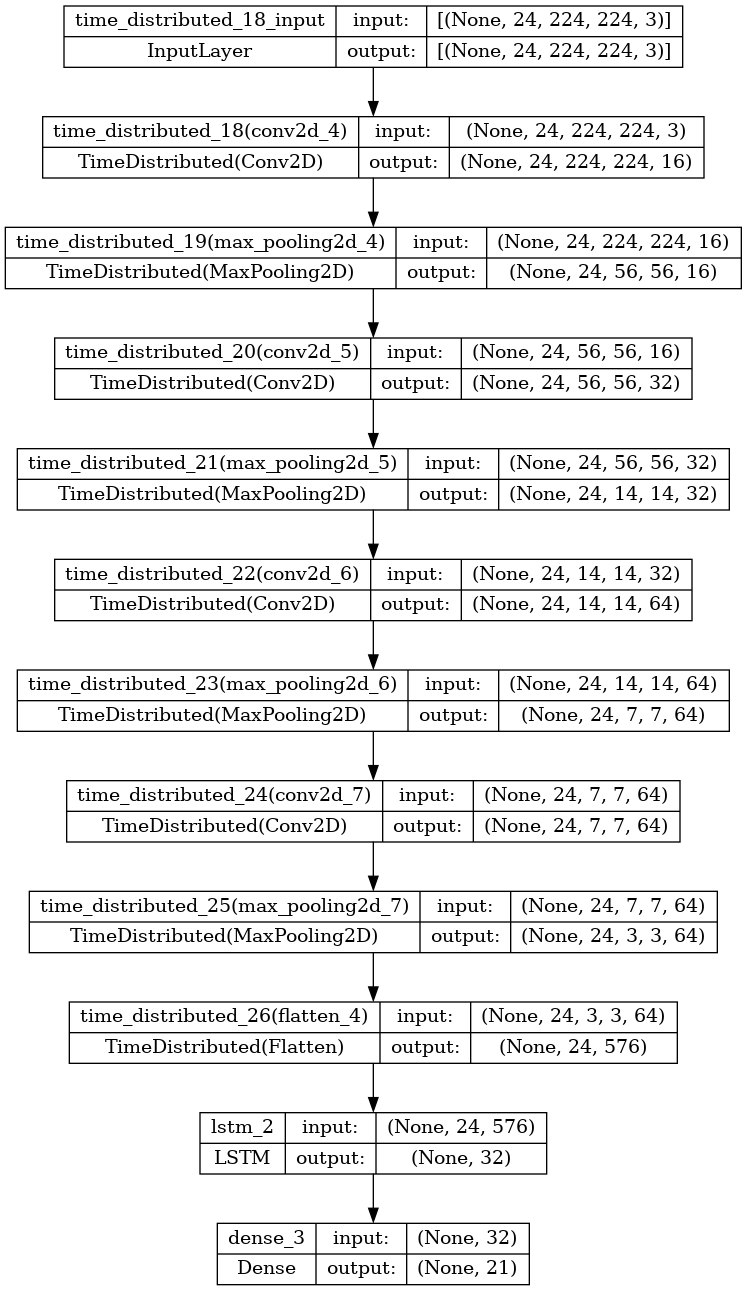

In [46]:
# Plot the structure of the contructed model.
plot_model(LRCN_model1, show_shapes = True, show_layer_names = True)

In [48]:
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model1.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
fit0c = LRCN_model1.fit(train_gen_0, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=5, validation_data=val_gen_0, validation_steps=len(test_video_paths_1)//batch_size)

Epoch 1/5
379/379 [==============================] - 270s 706ms/step - loss: 2.7536 - accuracy: 0.2798 - val_loss: 2.7826 - val_accuracy: 0.2881
Epoch 2/5
379/379 [==============================] - 261s 691ms/step - loss: 2.6718 - accuracy: 0.3109 - val_loss: 2.6625 - val_accuracy: 0.3068
Epoch 3/5
379/379 [==============================] - 257s 680ms/step - loss: 2.6666 - accuracy: 0.3039 - val_loss: 2.6906 - val_accuracy: 0.2938
Epoch 4/5
379/379 [==============================] - 267s 707ms/step - loss: 2.6783 - accuracy: 0.2983 - val_loss: 2.6769 - val_accuracy: 0.2963
Epoch 5/5
379/379 [==============================] - 267s 705ms/step - loss: 2.6847 - accuracy: 0.2944 - val_loss: 2.6820 - val_accuracy: 0.2938


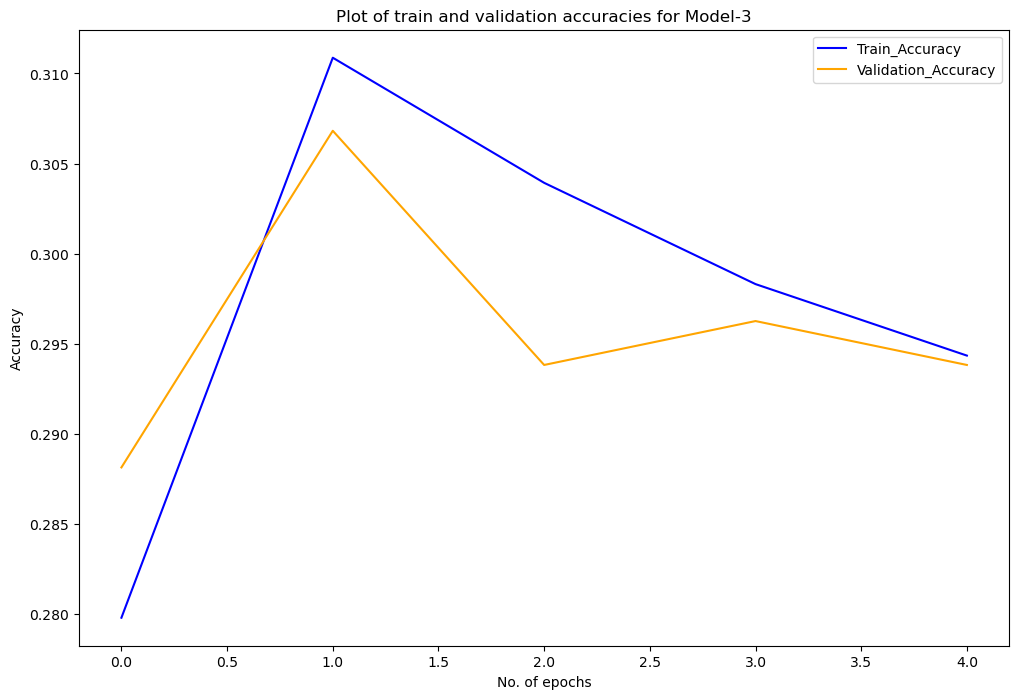

In [52]:
#plotting the training and validation accuracy vs epochs of Model-3
plt.figure(figsize = (12,8))
plt.plot(fit0c.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit0c.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-3")
plt.legend()
plt.show()

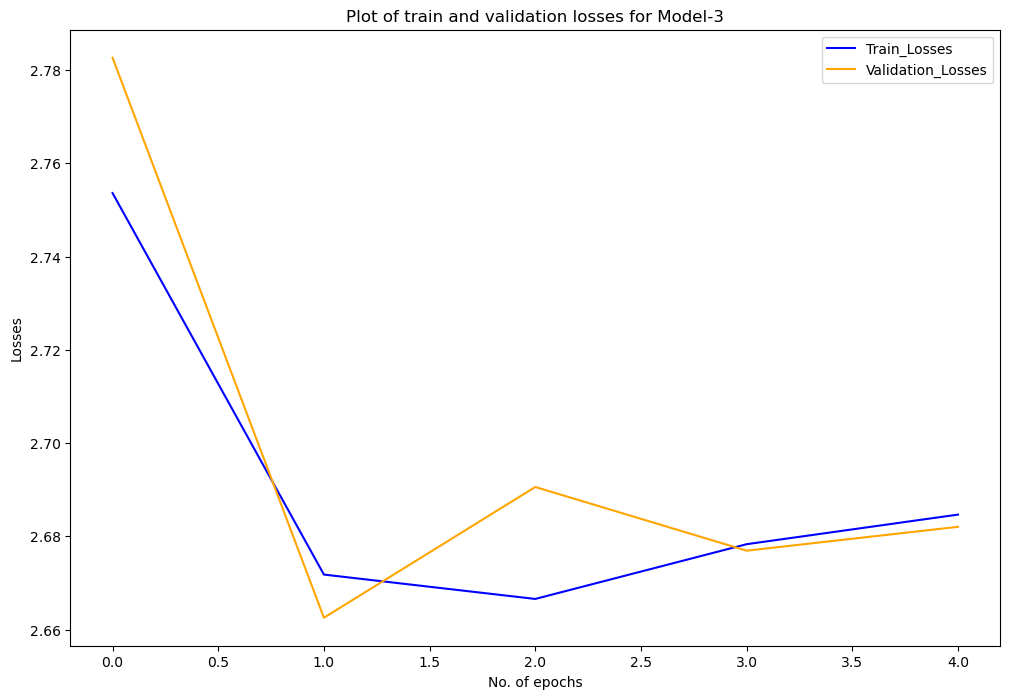

In [53]:
#plotting the training and validation losses vs epochs of Model-3
plt.figure(figsize = (12,8))
plt.plot(fit0c.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit0c.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-3")
plt.legend()
plt.show()

**Model-4: GRU**

In [25]:
# Define the GRU model to classify the video sequence based on extracted features
gru1 = Sequential()
#lstm.add(Flatten(input_shape=(24*7*7*512, )))
gru1.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(num_frames, 224,224,3)))
gru1.add(MaxPooling3D(pool_size=(2, 2, 2)))
gru1.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))
gru1.add(MaxPooling3D(pool_size=(2, 2, 2)))
gru1.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu'))
gru1.add(MaxPooling3D(pool_size=(2, 2, 2)))

gru1.add(Reshape((1, 26*26*128)))

gru1.add(GRU(512, input_shape=( 1,26*26*128), return_sequences=True))
#lstm.add(Dropout(0.5))
#lstm.add(LSTM(32, return_sequences=True))
#lstm.add(LSTM(32, return_sequences=True))
gru1.add(Flatten())
#lstm.add(Dense(256, activation='relu'))
#lstm.add(Dense(32, activation='relu'))
#lstm.add(Dropout(0.5))
gru1.add(Dense(num_classes, activation='softmax'))

gru1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 22, 222, 222, 32)  2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 11, 111, 111, 32)  0        
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 9, 109, 109, 64)   55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 4, 54, 54, 64)    0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 2, 52, 52, 128)    221312    
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 1, 26, 26, 128)   0

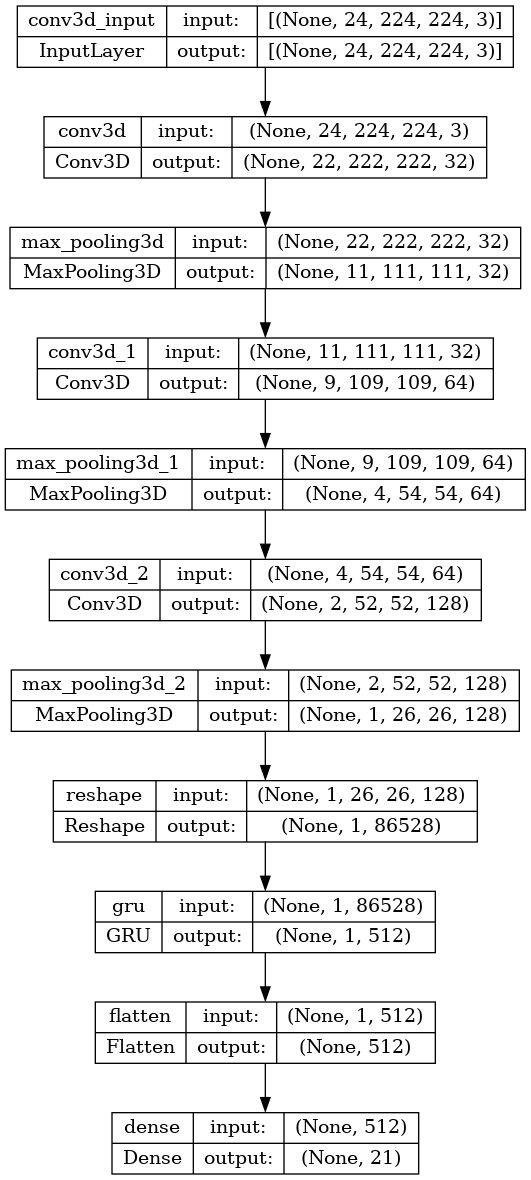

In [26]:
# Plot the structure of the contructed model.
plot_model(gru1, show_shapes = True, show_layer_names = True)

In [27]:
# Compile the LSTM model
gru1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


fit0d =gru1.fit(train_gen_0, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=3, validation_data=val_gen_0, validation_steps=len(test_video_paths_1)//batch_size)

Epoch 1/3
379/379 [==============================] - 331s 826ms/step - loss: 2.7820 - accuracy: 0.2991 - val_loss: 2.7719 - val_accuracy: 0.2955
Epoch 2/3
379/379 [==============================] - 278s 733ms/step - loss: 2.7562 - accuracy: 0.3003 - val_loss: 2.7547 - val_accuracy: 0.2979
Epoch 3/3
379/379 [==============================] - 289s 763ms/step - loss: 2.7621 - accuracy: 0.2990 - val_loss: 2.7984 - val_accuracy: 0.2938


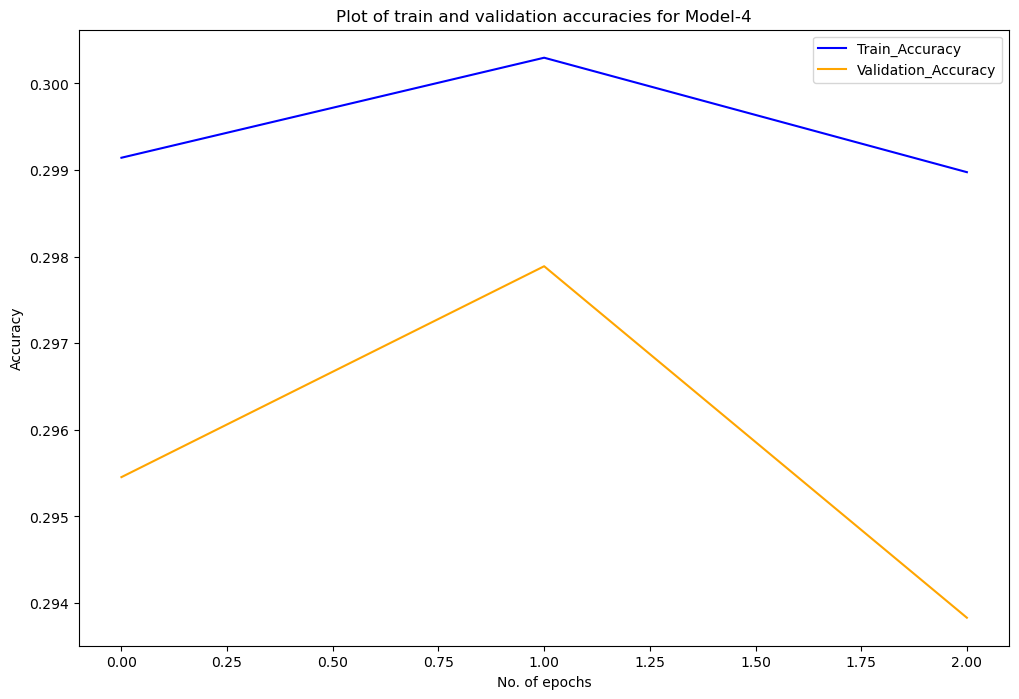

In [28]:
#plotting the training and validation accuracy vs epochs of Model-4
plt.figure(figsize = (12,8))
plt.plot(fit0d.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit0d.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-4")
plt.legend()
plt.show()

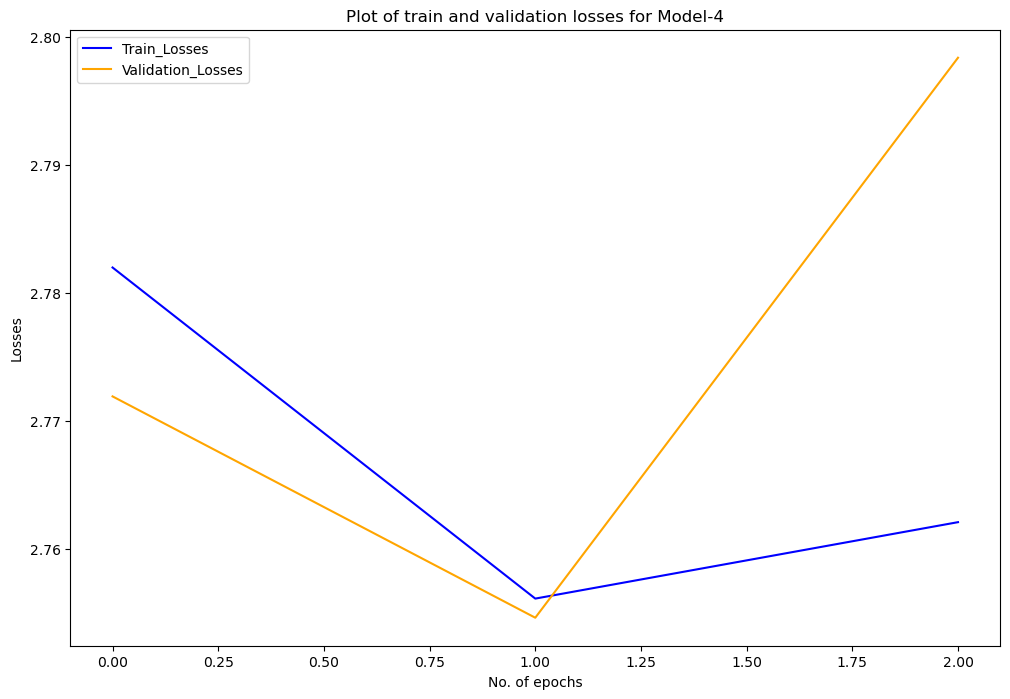

In [29]:
#plotting the training and validation losses vs epochs of Model-4
plt.figure(figsize = (12,8))
plt.plot(fit0d.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit0d.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-4")
plt.legend()
plt.show()

**Model-5: SimpleRNN**

In [30]:
# Define the GRU model to classify the video sequence based on extracted features
rnn1 = Sequential()
#lstm.add(Flatten(input_shape=(24*7*7*512, )))
rnn1.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(num_frames, 224,224,3)))
rnn1.add(MaxPooling3D(pool_size=(2, 2, 2)))
rnn1.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu'))
rnn1.add(MaxPooling3D(pool_size=(2, 2, 2)))
rnn1.add(Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu'))
rnn1.add(MaxPooling3D(pool_size=(2, 2, 2)))

rnn1.add(Reshape((1, 26*26*128)))

rnn1.add(GRU(512, input_shape=( 1,26*26*128), return_sequences=True))
#lstm.add(Dropout(0.5))
#lstm.add(LSTM(32, return_sequences=True))
#lstm.add(LSTM(32, return_sequences=True))
rnn1.add(Flatten())
#lstm.add(Dense(256, activation='relu'))
#lstm.add(Dense(32, activation='relu'))
#lstm.add(Dropout(0.5))
rnn1.add(Dense(num_classes, activation='softmax'))

rnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 22, 222, 222, 32)  2624      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 11, 111, 111, 32)  0        
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 9, 109, 109, 64)   55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 4, 54, 54, 64)    0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 2, 52, 52, 128)    221312    
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 1, 26, 26, 128)  

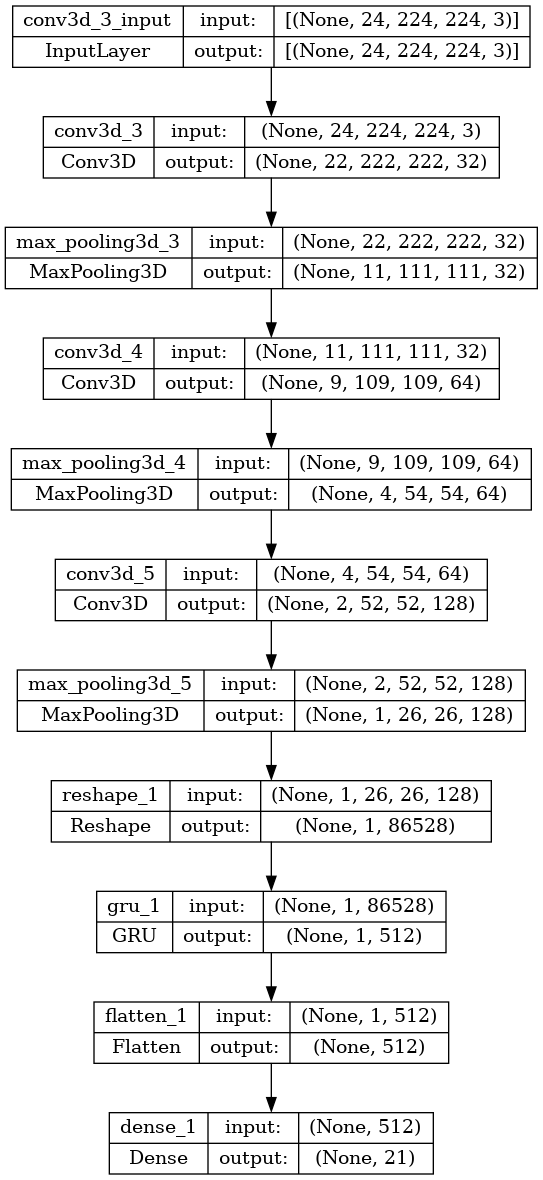

In [31]:
# Plot the structure of the contructed model.
plot_model(rnn1, show_shapes = True, show_layer_names = True)

In [32]:
# Compile the LSTM model
rnn1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


fit0e =rnn1.fit(train_gen_0, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=3, validation_data=val_gen_0, validation_steps=len(test_video_paths_1)//batch_size)

Epoch 1/3
379/379 [==============================] - 301s 788ms/step - loss: 2.7790 - accuracy: 0.2993 - val_loss: 2.7830 - val_accuracy: 0.2971
Epoch 2/3
379/379 [==============================] - 281s 743ms/step - loss: 2.7419 - accuracy: 0.3010 - val_loss: 2.7017 - val_accuracy: 0.2938
Epoch 3/3
379/379 [==============================] - 301s 796ms/step - loss: 2.7444 - accuracy: 0.2940 - val_loss: 2.7552 - val_accuracy: 0.2955


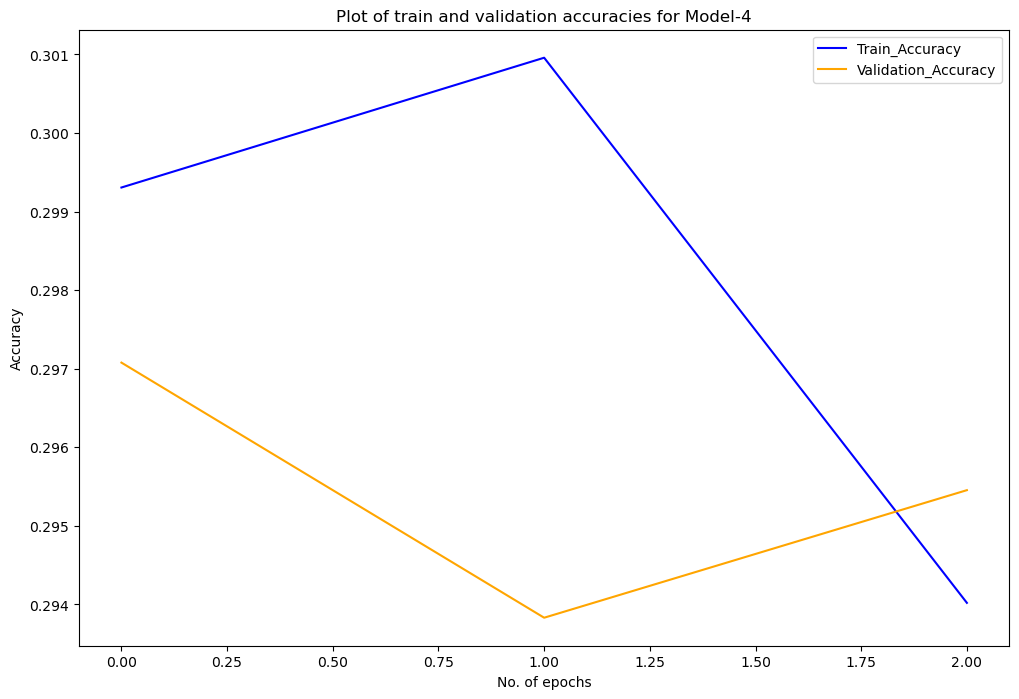

In [33]:
#plotting the training and validation accuracy vs epochs of Model-4
plt.figure(figsize = (12,8))
plt.plot(fit0e.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit0e.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-4")
plt.legend()
plt.show()

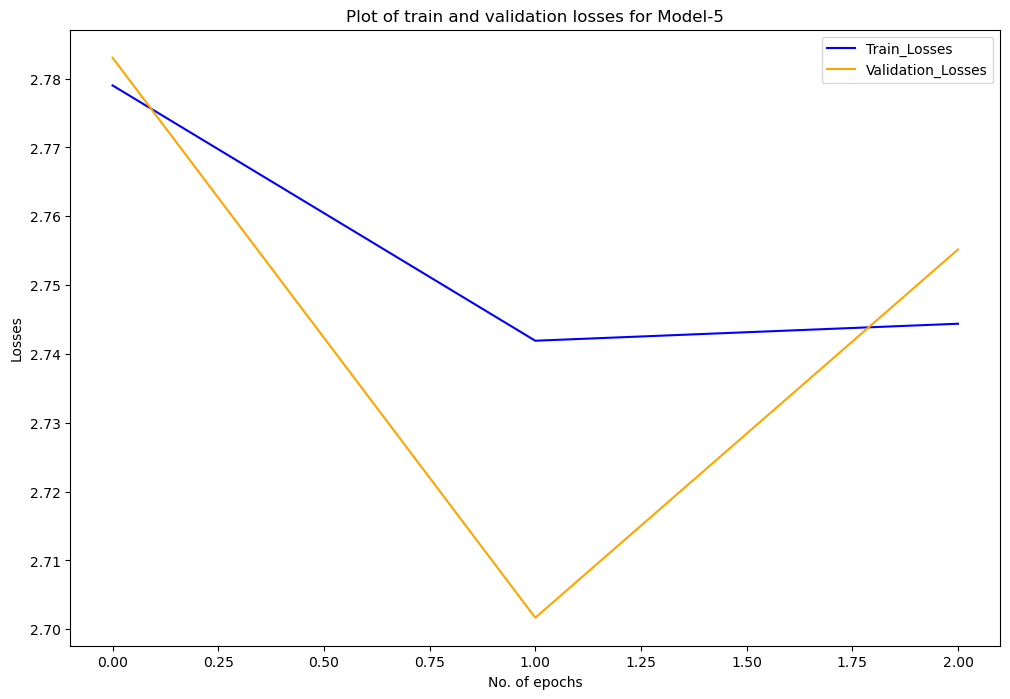

In [34]:
#plotting the training and validation losses vs epochs of Model-5
plt.figure(figsize = (12,8))
plt.plot(fit0e.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit0e.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-5")
plt.legend()
plt.show()

# **Data Loader with VGG-16 Feature Extraction**

In [26]:
# Define the VGG16 model to extract features from video frames
vgg_model = VGG16(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [27]:
def video_data_generator_VGG16(video_paths, labels, batch_size, num_classes, num_frames, frame_size, vgg):
    while True:
        # Shuffle the video paths and labels
        indices = np.arange(len(video_paths))
        np.random.shuffle(indices)
        video_paths = [video_paths[i] for i in indices]
        labels = [labels[i] for i in indices]

        folder_path = "/kaggle/input/ucf-modified/UCF-21-modified"

        # Loop through the video paths in batches
        for i in range(0, len(video_paths), batch_size):
            #print("\n", i)
            # Load the video frames and resize them to frame_size
            video_batch = []
            
            for path in video_paths[i:i+batch_size]:
                video_path = os.path.join(folder_path, path)
                video_frames = []
                #video_features = []
                video_capture = cv2.VideoCapture(video_path)
                num_frames_video = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
                step = num_frames_video // num_frames
                
                for j in range(num_frames_video):
                    ret, frame = video_capture.read()
                    if not ret:
                        break
                    if (j % step == 0) and (len(video_frames) < num_frames):
                                #print("\n", j)
                                #print("\nBefore resizing: ",frame)
                                frame_resized = cv2.resize(frame, frame_size)              # resizing frames
                                #print("\nAfter resizing", frames_resized)
                                #print("\nFrame shape is: ",frame_resized.shape)
                                #features_frame = vgg.predict(frame_resized)
                                video_frames.append(frame_resized)                             # this array is for for storing all frames of particular video
                                #video_features = np.vstack((video_features, features_frame))
                                #print("\nvideo features shape is: ",video_features.shape)
                video_capture.release()
                
                while len(video_frames) < num_frames:                                          # here i am verifying,if required no. of frames are extracted or not,
                    video_frames.append(np.zeros((224,224,3)))                                 #  if not, i am appending zero matrix of same shape to manage the corret shape

                if (np.array(video_frames)).shape != (num_frames, 224, 224, 3):                        # if video frames array is not of required shape,i will not process this batch
                     break
                
                video_frames = np.array(video_frames)
                #video_features = np.array(video_features)
                # Preprocess the frames using VGG16 preprocess_input function
                #video_frames = preprocess_input(video_frames)
                # Extract features using VGG16 model
                #print("\nVideo_frames has size: ", video_frames.shape)
                video_features = vgg.predict(video_frames, verbose=0)                         # instead of predicting features for each single frame of the video, i am predicting for for all frames of the video at once
                #print("\nVideo_features has size: ", video_features.shape)
                video_features_reshaped = video_features.reshape(num_frames,7*7*512)          # here i am flattening the features so that we can give it to lstm model
                video_batch.append(video_features_reshaped)                                   # here i am appending the video to thebatch array
            labels_batch = np.array(labels[i:i+batch_size])
            video_batch = np.array(video_batch)
            #print("\nVideo_batch shape is: ", video_batch.shape)
            #print("\nlabels_batch shape is: ", labels_batch.shape)
            
            # Yield the data batch
            yield video_batch, labels_batch

In [30]:
# Train the LSTM model using the video data generator function
train_gen1 = video_data_generator_VGG16(train_video_paths_1, train_labels_1, batch_size, num_classes, num_frames, frame_size, vgg_model)
val_gen1 = video_data_generator_VGG16(test_video_paths_1, test_labels_1, batch_size, num_classes, num_frames, frame_size, vgg_model)

**Model-1: LSTM**

In [62]:
# Define the LSTM model to classify the video sequence based on extracted features
lstm2 = Sequential()
#lstm.add(Flatten(input_shape=(24*7*7*512, )))
lstm2.add(LSTM(512, input_shape=(24, 7*7*512), return_sequences=True))
#lstm.add(Dropout(0.5))
#lstm.add(LSTM(32, return_sequences=True))
#lstm.add(LSTM(32, return_sequences=True))
lstm2.add(Flatten())
#lstm.add(Dense(256, activation='relu'))
#lstm.add(Dense(32, activation='relu'))
#lstm.add(Dropout(0.5))
lstm2.add(Dense(num_classes, activation='softmax'))

lstm2.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 24, 512)           52430848  
                                                                 
 flatten_6 (Flatten)         (None, 12288)             0         
                                                                 
 dense_5 (Dense)             (None, 21)                258069    
                                                                 
Total params: 52,688,917
Trainable params: 52,688,917
Non-trainable params: 0
_________________________________________________________________


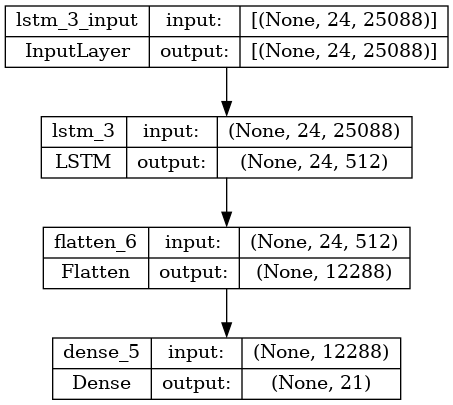

In [63]:
# Plot the structure of the contructed model.
plot_model(lstm2, show_shapes = True, show_layer_names = True)

In [38]:
# Compile the LSTM model
lstm2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


fit1a = lstm2.fit(train_gen1, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=5, validation_data=val_gen1, validation_steps=len(test_video_paths_1)//batch_size)

Epoch 1/5
379/379 [==============================] - 1046s 3s/step - loss: 0.9600 - accuracy: 0.7421 - val_loss: 1.0873 - val_accuracy: 0.7183
Epoch 2/5
379/379 [==============================] - 1005s 3s/step - loss: 0.2139 - accuracy: 0.9372 - val_loss: 1.0164 - val_accuracy: 0.7532
Epoch 3/5
379/379 [==============================] - 1012s 3s/step - loss: 0.1189 - accuracy: 0.9627 - val_loss: 1.0022 - val_accuracy: 0.7541
Epoch 4/5
379/379 [==============================] - 1023s 3s/step - loss: 0.0846 - accuracy: 0.9722 - val_loss: 0.9998 - val_accuracy: 0.7833
Epoch 5/5
379/379 [==============================] - 1057s 3s/step - loss: 0.1147 - accuracy: 0.9676 - val_loss: 0.8041 - val_accuracy: 0.8093


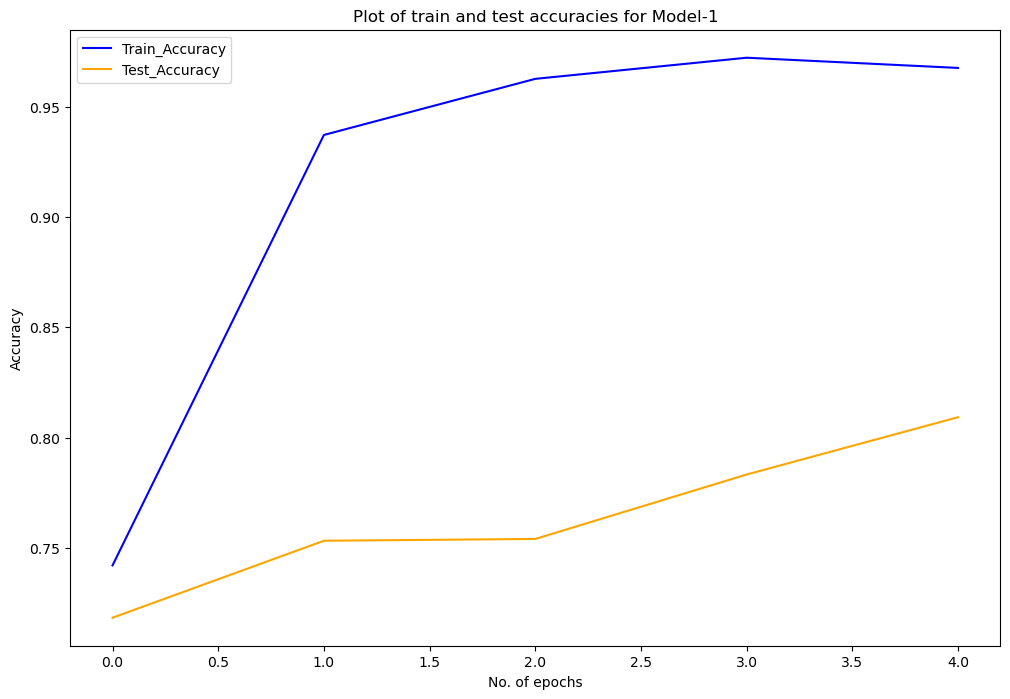

In [39]:
#plotting the training and validation accuracy vs epochs of Model-1
plt.figure(figsize = (12,8))
plt.plot(fit1a.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit1a.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-1")
plt.legend()
plt.show()

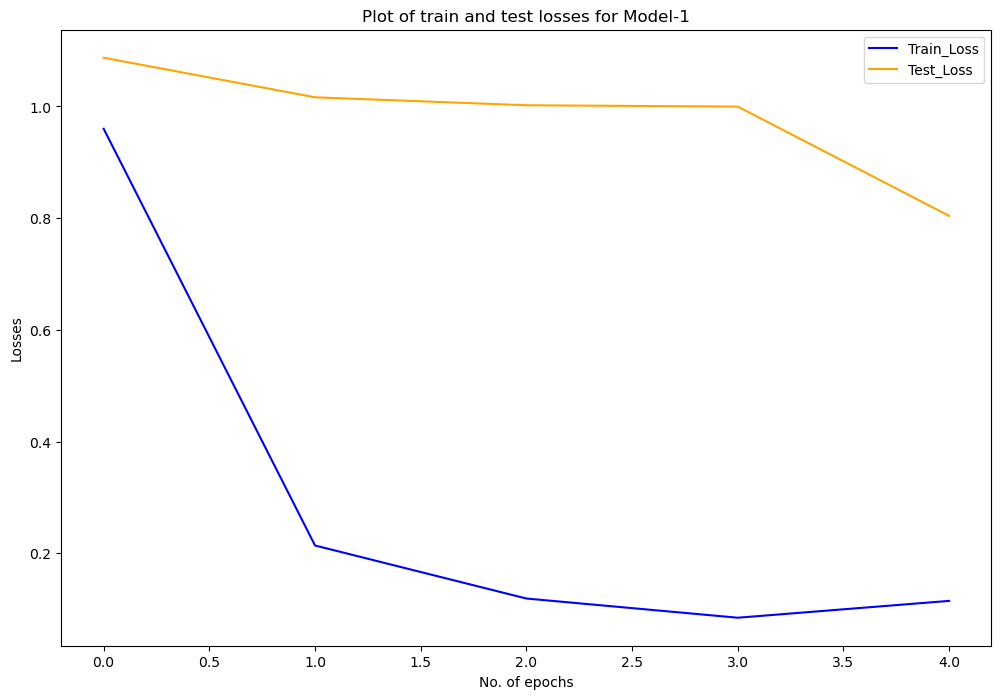

In [40]:
#plotting the training and validation losses vs epochs of Model-1
plt.figure(figsize = (12,8))
plt.plot(fit1a.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit1a.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-1")
plt.legend()
plt.show()

**Model-2: GRU**

In [22]:
# Define the GRU model to classify the video sequence based on extracted features
gru2 = Sequential()
gru2.add(GRU(512, input_shape=(24, 7*7*512), return_sequences=True))
#lstm.add(Dropout(0.5))
#lstm.add(LSTM(32, return_sequences=True))
#lstm.add(LSTM(32, return_sequences=True))
gru2.add(Flatten())
#lstm.add(Dense(256, activation='relu'))
#lstm.add(Dense(32, activation='relu'))
#lstm.add(Dropout(0.5))
gru2.add(Dense(num_classes, activation='softmax'))

gru2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 512)           39324672  
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 21)                258069    
                                                                 
Total params: 39,582,741
Trainable params: 39,582,741
Non-trainable params: 0
_________________________________________________________________


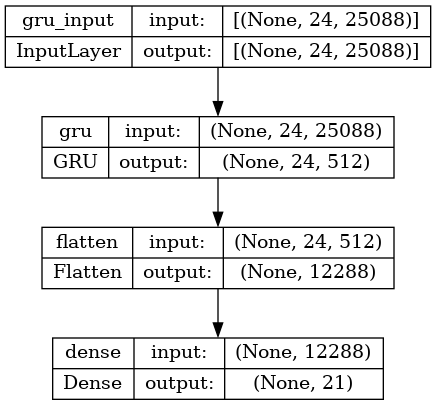

In [23]:
# Plot the structure of the contructed model.
plot_model(gru2, show_shapes = True, show_layer_names = True)

In [24]:
# Compile the LSTM model
gru2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


fit1b = gru2.fit(train_gen1, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=5, validation_data=val_gen1, validation_steps=len(test_video_paths_1)//batch_size)

Epoch 1/5
379/379 [==============================] - 1044s 3s/step - loss: 1.6851 - accuracy: 0.6557 - val_loss: 1.6508 - val_accuracy: 0.6940
Epoch 2/5
379/379 [==============================] - 1041s 3s/step - loss: 0.7924 - accuracy: 0.8497 - val_loss: 1.1866 - val_accuracy: 0.7654
Epoch 3/5
379/379 [==============================] - 1034s 3s/step - loss: 0.4491 - accuracy: 0.8996 - val_loss: 2.5586 - val_accuracy: 0.6250
Epoch 4/5
379/379 [==============================] - 1003s 3s/step - loss: 0.4153 - accuracy: 0.9111 - val_loss: 3.0041 - val_accuracy: 0.7135
Epoch 5/5
379/379 [==============================] - 1040s 3s/step - loss: 0.3947 - accuracy: 0.9326 - val_loss: 1.8223 - val_accuracy: 0.7744


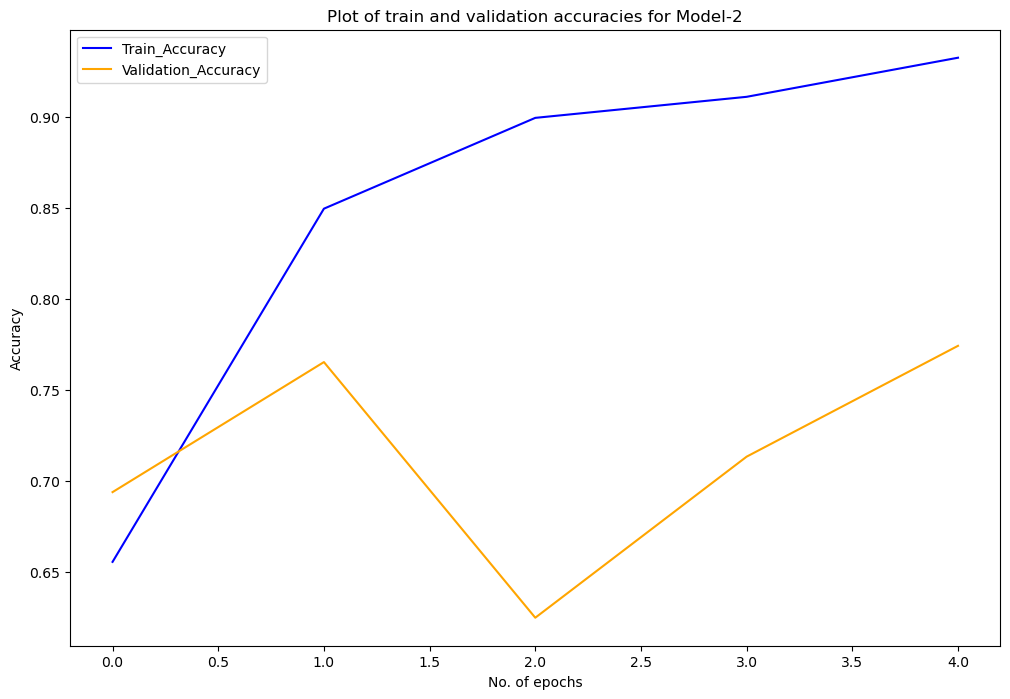

In [25]:
#plotting the training and validation accuracy vs epochs of Model-2
plt.figure(figsize = (12,8))
plt.plot(fit1b.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit1b.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-2")
plt.legend()
plt.show()

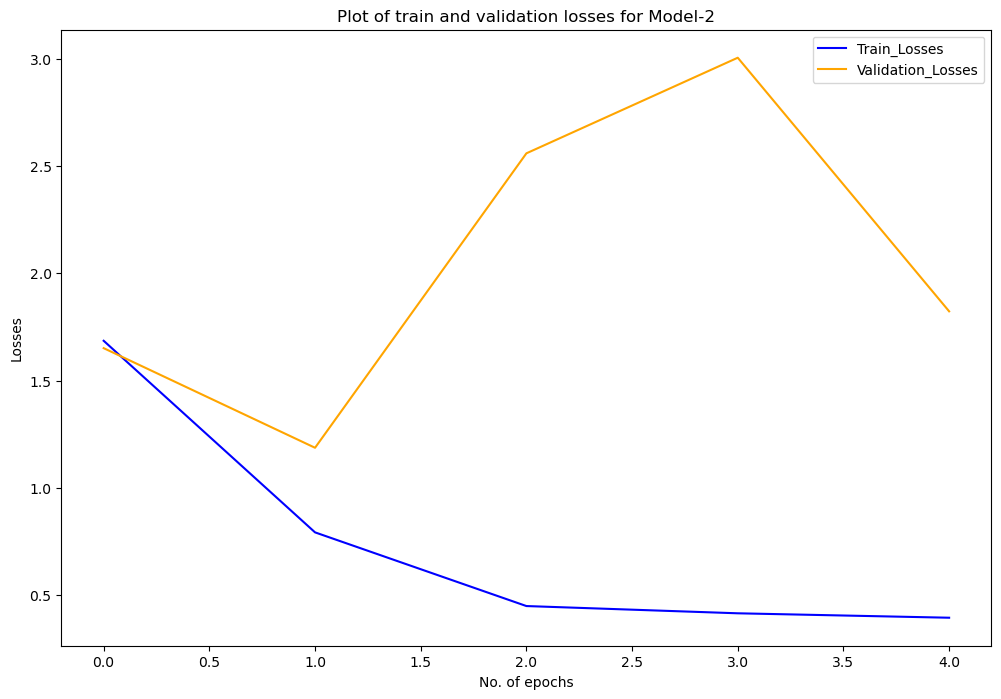

In [26]:
#plotting the training and validation losses vs epochs of Model-2
plt.figure(figsize = (12,8))
plt.plot(fit1b.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit1b.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-2")
plt.legend()
plt.show()

**Model-3: SimpleRNN**

In [31]:
# Define the GRU model to classify the video sequence based on extracted features
rnn2 = Sequential()
rnn2.add(SimpleRNN(512, input_shape=(24, 7*7*512), return_sequences=True))
#lstm.add(Dropout(0.5))
#lstm.add(LSTM(32, return_sequences=True))
#lstm.add(LSTM(32, return_sequences=True))
rnn2.add(Flatten())
#lstm.add(Dense(256, activation='relu'))
#lstm.add(Dense(32, activation='relu'))
#lstm.add(Dropout(0.5))
rnn2.add(Dense(num_classes, activation='softmax'))

rnn2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 512)           13107712  
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 21)                258069    
                                                                 
Total params: 13,365,781
Trainable params: 13,365,781
Non-trainable params: 0
_________________________________________________________________


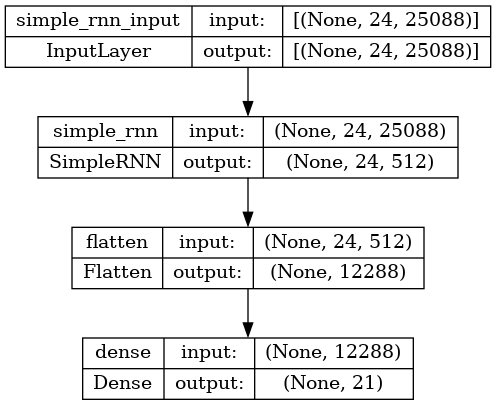

In [32]:
# Plot the structure of the contructed model.
plot_model(rnn2, show_shapes = True, show_layer_names = True)

In [33]:
# Compile the model and specify loss function, optimizer and metrics to the model.
rnn2.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
fit1c = rnn2.fit(train_gen1, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=4, validation_data=val_gen1, validation_steps=len(test_video_paths_1)//batch_size)

Epoch 1/4
379/379 [==============================] - 1003s 3s/step - loss: 3.5994 - accuracy: 0.5999 - val_loss: 3.2612 - val_accuracy: 0.6144
Epoch 2/4
379/379 [==============================] - 1017s 3s/step - loss: 1.9513 - accuracy: 0.7800 - val_loss: 2.7598 - val_accuracy: 0.6997
Epoch 3/4
379/379 [==============================] - 1015s 3s/step - loss: 1.0272 - accuracy: 0.8761 - val_loss: 5.6622 - val_accuracy: 0.6380
Epoch 4/4
379/379 [==============================] - 977s 3s/step - loss: 0.7894 - accuracy: 0.9052 - val_loss: 4.5510 - val_accuracy: 0.6981


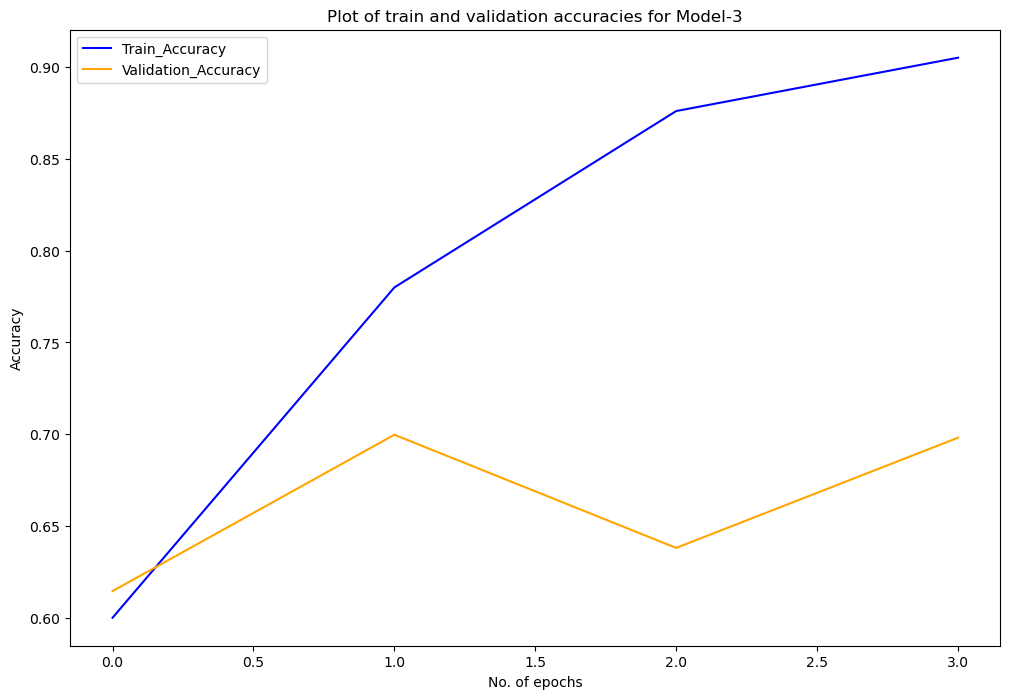

In [34]:
#plotting the training and validation accuracy vs epochs of Model-3
plt.figure(figsize = (12,8))
plt.plot(fit1c.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit1c.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-3")
plt.legend()
plt.show()

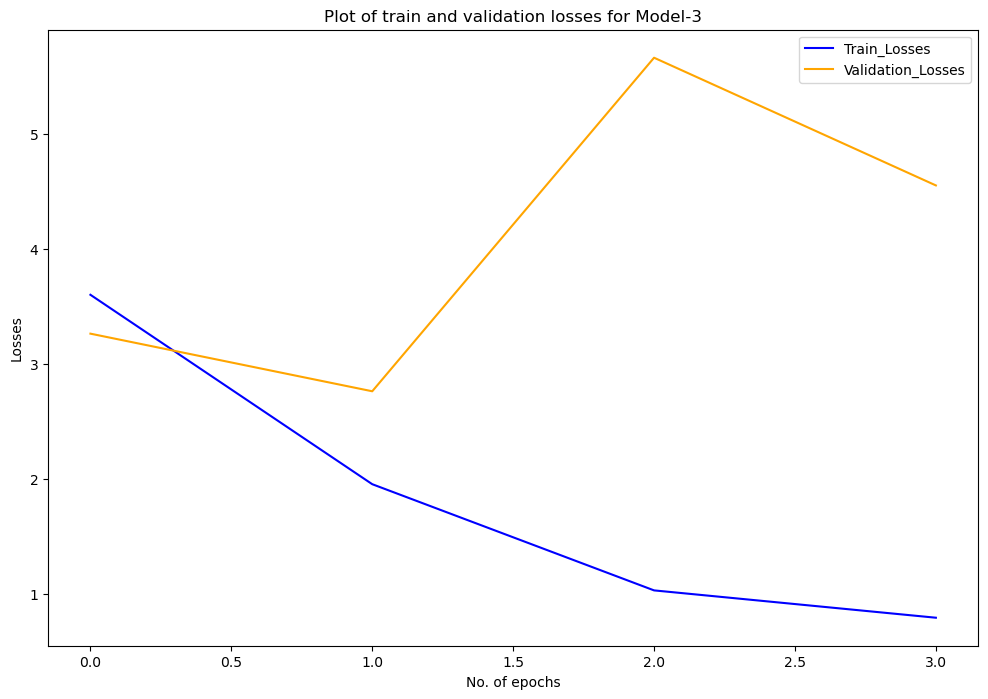

In [35]:
#plotting the training and validation losses vs epochs of Model-3
plt.figure(figsize = (12,8))
plt.plot(fit1c.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit1c.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-3")
plt.legend()
plt.show()

# **Data Loader with Resnet-50 Feature Extraction**

In [14]:
# Define the Resnet-50 model to extract features from video frames
resnet_model = ResNet50(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [16]:
def video_data_generator_ResNet50(video_paths, labels, batch_size, num_classes, num_frames, frame_size, resnet):
    while True:
        # Shuffle the video paths and labels
        indices = np.arange(len(video_paths))
        np.random.shuffle(indices)
        video_paths = [video_paths[i] for i in indices]
        labels = [labels[i] for i in indices]

        folder_path = "/kaggle/input/ucf-modified/UCF-21-modified"

        # Loop through the video paths in batches
        for i in range(0, len(video_paths), batch_size):
            #print("\n", i)
            # Load the video frames and resize them to frame_size
            video_batch = []
            
            for path in video_paths[i:i+batch_size]:
                video_path = os.path.join(folder_path, path)
                video_frames = []
                #video_features = []
                video_capture = cv2.VideoCapture(video_path)
                num_frames_video = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
                step = num_frames_video // num_frames
                
                for j in range(num_frames_video):
                    ret, frame = video_capture.read()
                    if not ret:
                        break
                    if (j % step == 0) and (len(video_frames) < num_frames):
                                #print("\n", j)
                                #print("\nBefore resizing: ",frame)
                                frame_resized = cv2.resize(frame, frame_size)              # resizing frames
                                #print("\nAfter resizing", frames_resized)
                                #print("\nFrame shape is: ",frame_resized.shape)
                                #features_frame = vgg.predict(frame_resized)
                                video_frames.append(frame_resized)                             # this array is for for storing all frames of particular video
                                #video_features = np.vstack((video_features, features_frame))
                                #print("\nvideo features shape is: ",video_features.shape)
                video_capture.release()
                
                while len(video_frames) < num_frames:                                          # here i am verifying,if required no. of frames are extracted or not,
                    video_frames.append(np.zeros((224,224,3)))                                 #  if not, i am appending zero matrix of same shape to manage the corret shape

                if (np.array(video_frames)).shape != (num_frames, 224, 224, 3):                        # if video frames array is not of required shape,i will not process this batch
                     break
                
                video_frames = np.array(video_frames)
                #video_features = np.array(video_features)
                # Preprocess the frames using VGG16 preprocess_input function
                #video_frames = preprocess_input(video_frames)
                # Extract features using VGG16 model
                #print("\nVideo_frames has size: ", video_frames.shape)
                video_features = resnet.predict(video_frames, verbose=0)                         # instead of predicting features for each single frame of the video, i am predicting for for all frames of the video at once
                #print("\nVideo_features has size: ", video_features.shape)
                video_features_reshaped = video_features.reshape(num_frames,7*7*2048)          # here i am flattening the features so that we can give it to lstm model
                video_batch.append(video_features_reshaped)                                   # here i am appending the video to thebatch array
            labels_batch = np.array(labels[i:i+batch_size])
            video_batch = np.array(video_batch)
            #print("\nVideo_batch shape is: ", video_batch.shape)
            #print("\nlabels_batch shape is: ", labels_batch.shape)
            
            # Yield the data batch
            yield video_batch, labels_batch

In [17]:
# Train the LSTM model using the video data generator function
train_gen2 = video_data_generator_ResNet50(train_video_paths_1, train_labels_1, batch_size, num_classes, num_frames, frame_size, resnet_model)
val_gen2 = video_data_generator_ResNet50(test_video_paths_1, test_labels_1, batch_size, num_classes, num_frames, frame_size, resnet_model)

**Model-1**

In [24]:
# Define the LSTM model to classify the video sequence based on extracted features
lstm3 = Sequential()
#lstm.add(Flatten(input_shape=(24*7*7*512, )))
lstm3.add(LSTM(512, input_shape=(24, 7*7*2048), return_sequences=True))
#lstm.add(Dropout(0.5))
#lstm.add(LSTM(32, return_sequences=True))
#lstm.add(LSTM(32, return_sequences=True))
lstm3.add(Flatten())
#lstm.add(Dense(256, activation='relu'))
#lstm.add(Dense(32, activation='relu'))
#lstm.add(Dropout(0.5))
lstm3.add(Dense(num_classes, activation='softmax'))

lstm3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 512)           206571520 
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 21)                258069    
                                                                 
Total params: 206,829,589
Trainable params: 206,829,589
Non-trainable params: 0
_________________________________________________________________


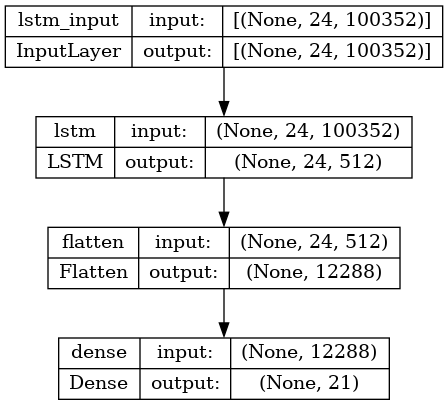

In [25]:
# Plot the structure of the contructed model.
plot_model(lstm3, show_shapes = True, show_layer_names = True)

In [26]:
# Compile the LSTM model
lstm3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


fit2a = lstm3.fit(train_gen2, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=4, validation_data=val_gen2, validation_steps=len(test_video_paths_1)//batch_size)

Epoch 1/4
379/379 [==============================] - 1134s 3s/step - loss: 1.5255 - accuracy: 0.6369 - val_loss: 1.0003 - val_accuracy: 0.7183
Epoch 2/4
379/379 [==============================] - 1108s 3s/step - loss: 0.4019 - accuracy: 0.8827 - val_loss: 0.6697 - val_accuracy: 0.8076
Epoch 3/4
379/379 [==============================] - 1106s 3s/step - loss: 0.2434 - accuracy: 0.9283 - val_loss: 0.9586 - val_accuracy: 0.7881
Epoch 4/4
379/379 [==============================] - 1116s 3s/step - loss: 0.1106 - accuracy: 0.9689 - val_loss: 1.1851 - val_accuracy: 0.7508


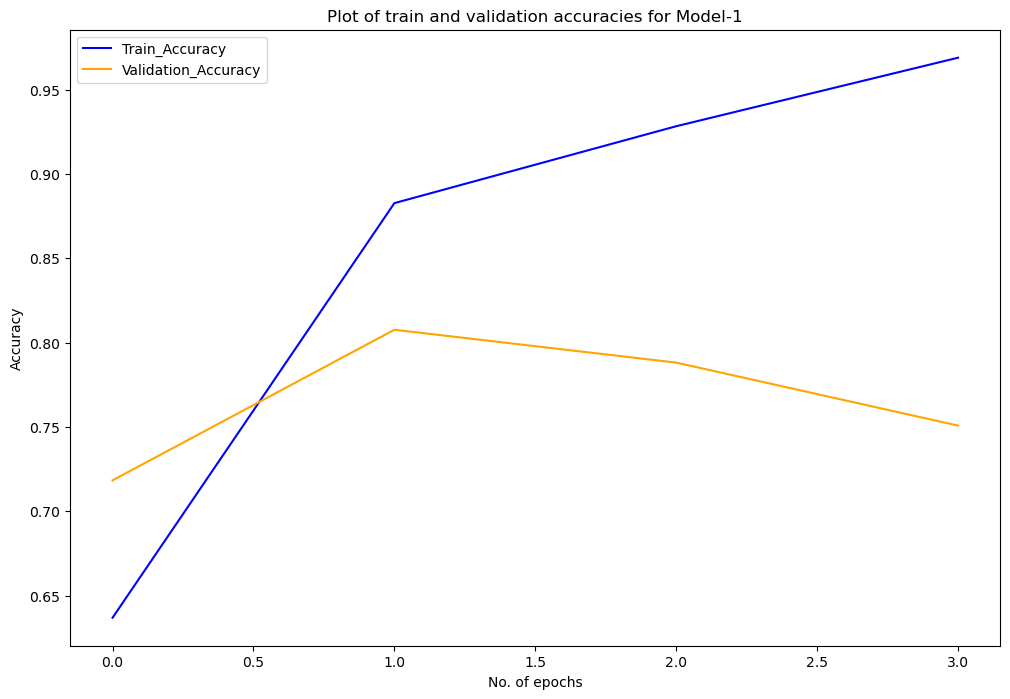

In [27]:
#plotting the training and validation accuracy vs epochs of Model-1
plt.figure(figsize = (12,8))
plt.plot(fit2a.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit2a.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-1")
plt.legend()
plt.show()

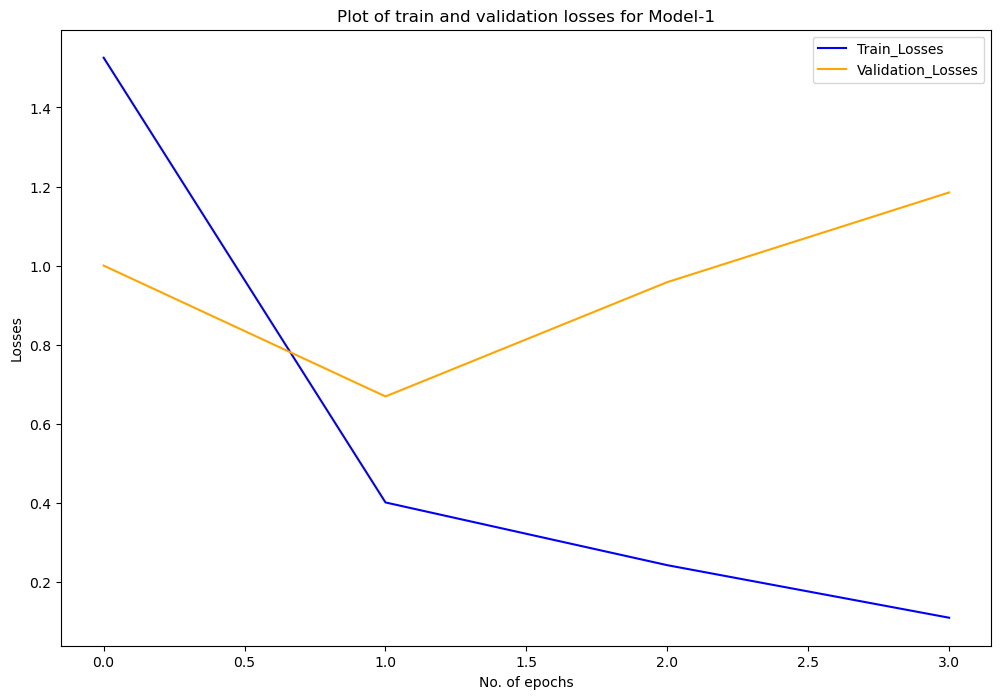

In [28]:
#plotting the training and validation losses vs epochs of Model-1
plt.figure(figsize = (12,8))
plt.plot(fit2a.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit2a.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-1")
plt.legend()
plt.show()

**Model-2: GRU**

In [27]:
# Define the GRU model to classify the video sequence based on extracted features
gru3 = Sequential()
gru3.add(GRU(512, input_shape=(24, 7*7*2048), return_sequences=True))
#lstm.add(Dropout(0.5))
#lstm.add(LSTM(32, return_sequences=True))
#lstm.add(LSTM(32, return_sequences=True))
gru3.add(Flatten())
#lstm.add(Dense(256, activation='relu'))
#lstm.add(Dense(32, activation='relu'))
#lstm.add(Dropout(0.5))
gru3.add(Dense(num_classes, activation='softmax'))

gru3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 24, 512)           154930176 
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 21)                258069    
                                                                 
Total params: 155,188,245
Trainable params: 155,188,245
Non-trainable params: 0
_________________________________________________________________


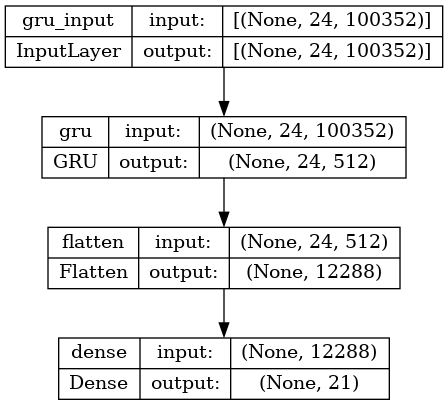

In [28]:
# Plot the structure of the contructed model.
plot_model(gru3, show_shapes = True, show_layer_names = True)

In [29]:
# Compile the LSTM model
gru3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


fit2b = gru3.fit(train_gen2, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=4, validation_data=val_gen2, validation_steps=len(test_video_paths_1)//batch_size)

Epoch 1/4
379/379 [==============================] - 1085s 3s/step - loss: 2.2787 - accuracy: 0.5646 - val_loss: 1.4817 - val_accuracy: 0.6615
Epoch 2/4
379/379 [==============================] - 1038s 3s/step - loss: 1.1313 - accuracy: 0.7763 - val_loss: 1.6628 - val_accuracy: 0.7305
Epoch 3/4
379/379 [==============================] - 1074s 3s/step - loss: 0.8961 - accuracy: 0.8249 - val_loss: 2.5216 - val_accuracy: 0.6737
Epoch 4/4
379/379 [==============================] - 1073s 3s/step - loss: 0.8076 - accuracy: 0.8573 - val_loss: 1.6916 - val_accuracy: 0.7524


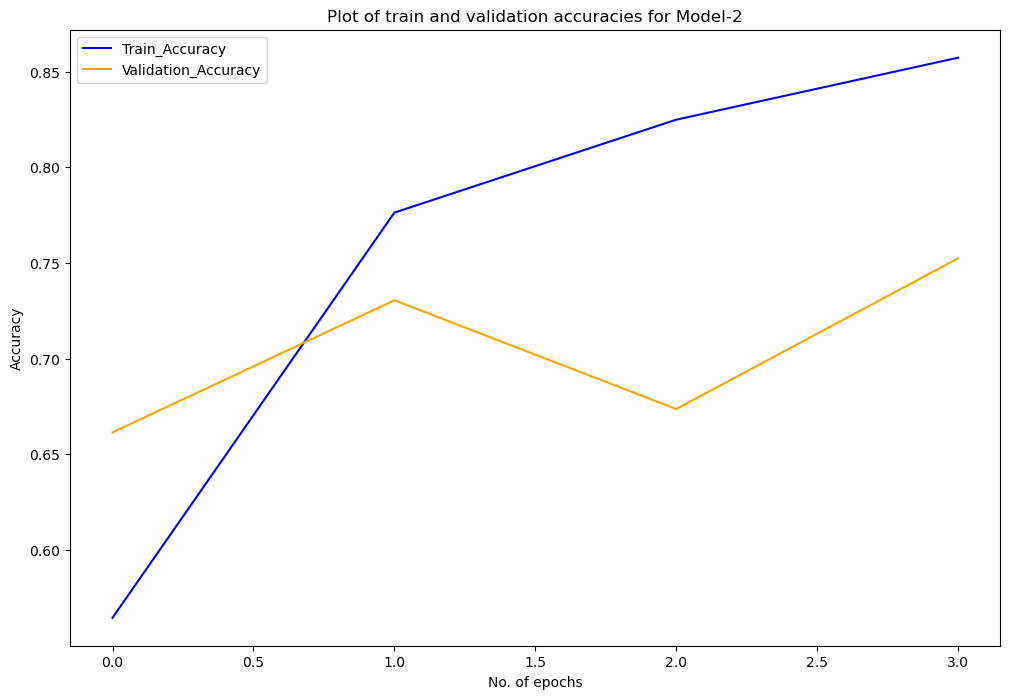

In [30]:
#plotting the training and validation accuracy vs epochs of Model-2
plt.figure(figsize = (12,8))
plt.plot(fit2b.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit2b.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-2")
plt.legend()
plt.show()

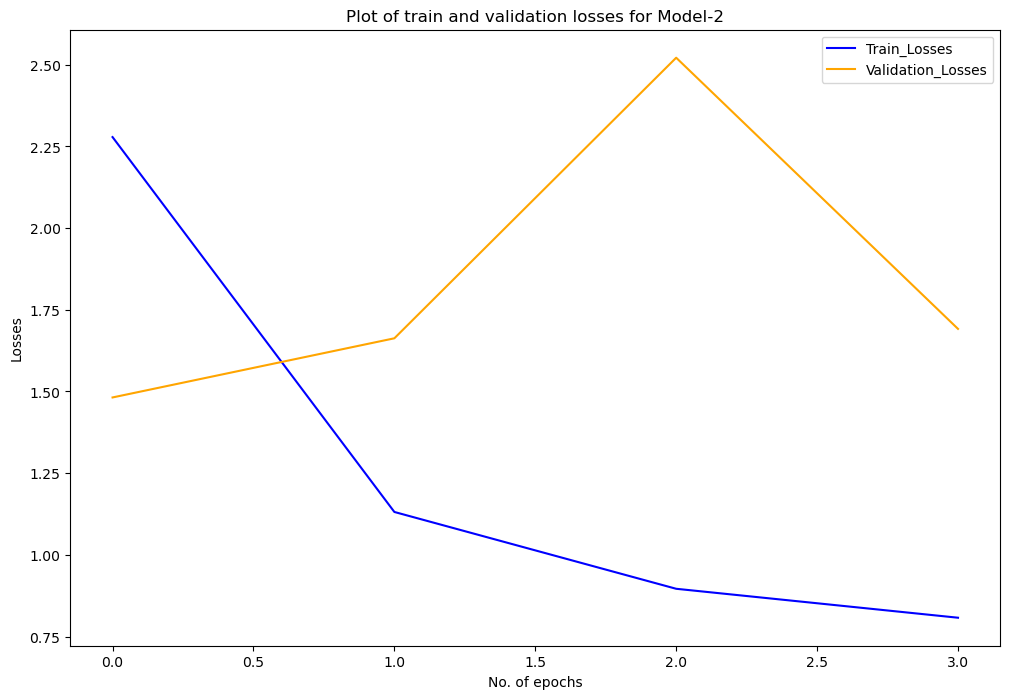

In [31]:
#plotting the training and validation losses vs epochs of Model-2
plt.figure(figsize = (12,8))
plt.plot(fit2b.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit2b.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-2")
plt.legend()
plt.show()

**Model-3: SimpleRNN**

In [18]:
# Define the GRU model to classify the video sequence based on extracted features
rnn3 = Sequential()
rnn3.add(SimpleRNN(512, input_shape=(24, 7*7*2048), return_sequences=True))
#lstm.add(Dropout(0.5))
#lstm.add(LSTM(32, return_sequences=True))
#lstm.add(LSTM(32, return_sequences=True))
rnn3.add(Flatten())
#lstm.add(Dense(256, activation='relu'))
#lstm.add(Dense(32, activation='relu'))
#lstm.add(Dropout(0.5))
rnn3.add(Dense(num_classes, activation='softmax'))

rnn3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 512)           51642880  
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 21)                258069    
                                                                 
Total params: 51,900,949
Trainable params: 51,900,949
Non-trainable params: 0
_________________________________________________________________


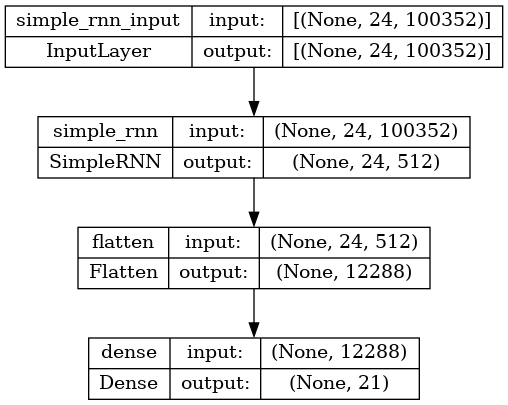

In [19]:
# Plot the structure of the contructed model.
plot_model(rnn3, show_shapes = True, show_layer_names = True)

In [20]:
# Compile the LSTM model
rnn3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


fit2c = rnn3.fit(train_gen2, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=4, validation_data=val_gen2, validation_steps=len(test_video_paths_1)//batch_size)

Epoch 1/4
379/379 [==============================] - 1080s 3s/step - loss: 4.3289 - accuracy: 0.5125 - val_loss: 4.1873 - val_accuracy: 0.5820
Epoch 2/4
379/379 [==============================] - 1063s 3s/step - loss: 2.5369 - accuracy: 0.7023 - val_loss: 2.4227 - val_accuracy: 0.6696
Epoch 3/4
379/379 [==============================] - 1068s 3s/step - loss: 1.7138 - accuracy: 0.8067 - val_loss: 2.3683 - val_accuracy: 0.7167
Epoch 4/4
379/379 [==============================] - 1078s 3s/step - loss: 1.1791 - accuracy: 0.8649 - val_loss: 2.6226 - val_accuracy: 0.7565


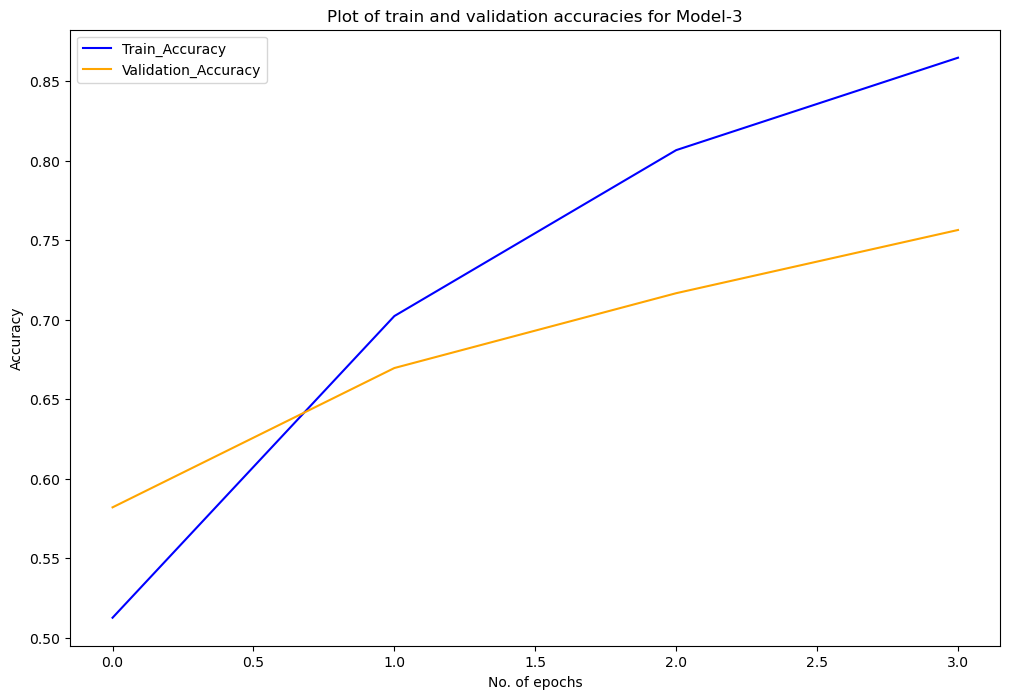

In [21]:
#plotting the training and validation accuracy vs epochs of Model-3
plt.figure(figsize = (12,8))
plt.plot(fit2c.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit2c.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-3")
plt.legend()
plt.show()

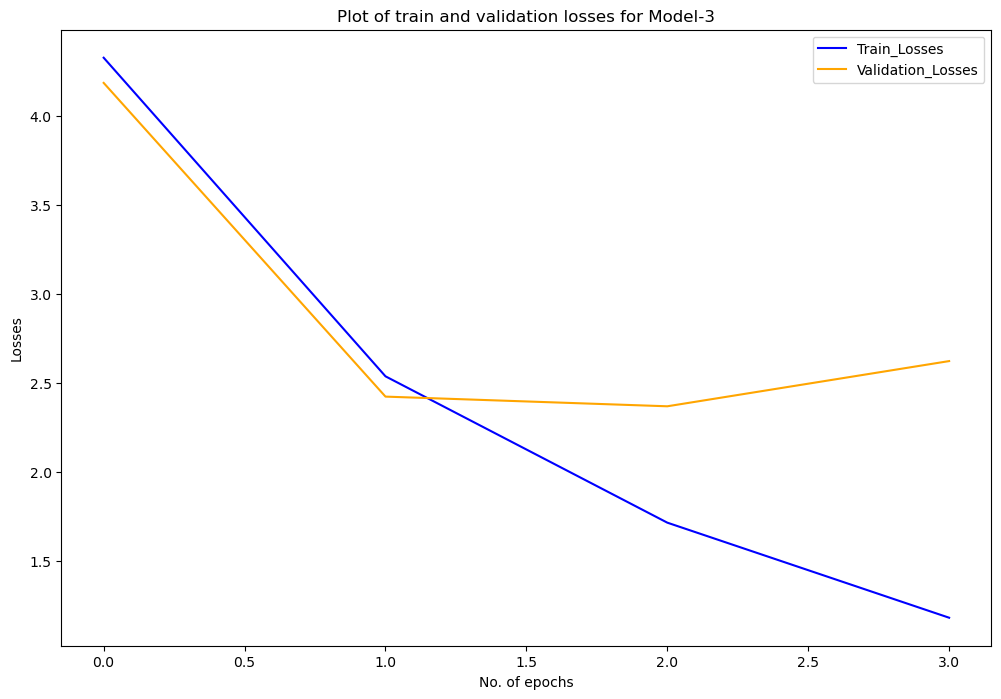

In [22]:
#plotting the training and validation losses vs epochs of Model-3
plt.figure(figsize = (12,8))
plt.plot(fit2c.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit2c.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-3")
plt.legend()
plt.show()

# **Data Loader with Efficient Net-B7 Feature Extraction**

In [16]:
# Define the Efficient Net-B7 model to extract features from video frames
effnet_model = EfficientNetB7(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

258076736/258076736 [==============================] - 2s 0us/step


In [17]:
def video_data_generator_EfficientNetB7(video_paths, labels, batch_size, num_classes, num_frames, frame_size, effnet):
    while True:
        # Shuffle the video paths and labels
        indices = np.arange(len(video_paths))
        np.random.shuffle(indices)
        video_paths = [video_paths[i] for i in indices]
        labels = [labels[i] for i in indices]

        folder_path = "/kaggle/input/ucf-modified/UCF-21-modified"

        # Loop through the video paths in batches
        for i in range(0, len(video_paths), batch_size):
            #print("\n", i)
            # Load the video frames and resize them to frame_size
            video_batch = []
            
            for path in video_paths[i:i+batch_size]:
                video_path = os.path.join(folder_path, path)
                video_frames = []
                #video_features = []
                video_capture = cv2.VideoCapture(video_path)
                num_frames_video = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
                step = num_frames_video // num_frames
                
                for j in range(num_frames_video):
                    ret, frame = video_capture.read()
                    if not ret:
                        break
                    if (j % step == 0) and (len(video_frames) < num_frames):
                                #print("\n", j)
                                #print("\nBefore resizing: ",frame)
                                frame_resized = cv2.resize(frame, frame_size)              # resizing frames
                                #print("\nAfter resizing", frames_resized)
                                #print("\nFrame shape is: ",frame_resized.shape)
                                #features_frame = vgg.predict(frame_resized)
                                video_frames.append(frame_resized)                             # this array is for for storing all frames of particular video
                                #video_features = np.vstack((video_features, features_frame))
                                #print("\nvideo features shape is: ",video_features.shape)
                video_capture.release()
                
                while len(video_frames) < num_frames:                                          # here i am verifying,if required no. of frames are extracted or not,
                    video_frames.append(np.zeros((224,224,3)))                                 #  if not, i am appending zero matrix of same shape to manage the corret shape

                if (np.array(video_frames)).shape != (num_frames, 224, 224, 3):                        # if video frames array is not of required shape,i will not process this batch
                     break
                
                video_frames = np.array(video_frames)
                #video_features = np.array(video_features)
                # Preprocess the frames using VGG16 preprocess_input function
                #video_frames = preprocess_input(video_frames)
                # Extract features using VGG16 model
                #print("\nVideo_frames has size: ", video_frames.shape)
                video_features = effnet.predict(video_frames, verbose=0)                         # instead of predicting features for each single frame of the video, i am predicting for for all frames of the video at once
                #print("\nVideo_features has size: ", video_features.shape)
                video_features_reshaped = video_features.reshape(num_frames,7*7*2560)          # here i am flattening the features so that we can give it to lstm model
                video_batch.append(video_features_reshaped)                                   # here i am appending the video to thebatch array
            labels_batch = np.array(labels[i:i+batch_size])
            video_batch = np.array(video_batch)
            #print("\nVideo_batch shape is: ", video_batch.shape)
            #print("\nlabels_batch shape is: ", labels_batch.shape)
            
            # Yield the data batch
            yield video_batch, labels_batch

In [18]:
# Train the LSTM model using the video data generator function
train_gen3 = video_data_generator_EfficientNetB7(train_video_paths_1, train_labels_1, batch_size, num_classes, num_frames, frame_size, effnet_model)
val_gen3 = video_data_generator_EfficientNetB7(test_video_paths_1, test_labels_1, batch_size, num_classes, num_frames, frame_size, effnet_model)

**Model-1: LSTM**

In [19]:
# Define the LSTM model to classify the video sequence based on extracted features
lstm4 = Sequential()
#lstm.add(Flatten(input_shape=(24*7*7*512, )))
lstm4.add(LSTM(512, input_shape=(24, 7*7*2560), return_sequences=True))
#lstm.add(Dropout(0.5))
#lstm.add(LSTM(32, return_sequences=True))
#lstm.add(LSTM(32, return_sequences=True))
lstm4.add(Flatten())
#lstm.add(Dense(256, activation='relu'))
#lstm.add(Dense(32, activation='relu'))
#lstm.add(Dropout(0.5))
lstm4.add(Dense(num_classes, activation='softmax'))

lstm4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 512)           257951744 
                                                                 
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 21)                258069    
                                                                 
Total params: 258,209,813
Trainable params: 258,209,813
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Plot the structure of the contructed model.
plot_model(lstm4, show_shapes = True, show_layer_names = True)

In [ ]:
# Compile the LSTM model
lstm4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


fit3a = lstm4.fit(train_gen3, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=3, validation_data=val_gen3, validation_steps=len(test_video_paths_1)//batch_size)

Epoch 1/3
379/379 [==============================] - 1959s 5s/step - loss: 0.8334 - accuracy: 0.7717 - val_loss: 0.6313 - val_accuracy: 0.8149
Epoch 2/3
142/379 [==========>...................] - ETA: 14:13 - loss: 0.3531 - accuracy: 0.8935

In [ ]:
#plotting the training and validation accuracy vs epochs of Model-1
plt.figure(figsize = (12,8))
plt.plot(fit3a.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit3a.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-1")
plt.legend()
plt.show()

In [ ]:
#plotting the training and validation losses vs epochs of Model-1
plt.figure(figsize = (12,8))
plt.plot(fit3a.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit3a.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-1")
plt.legend()
plt.show()

**Model-2: GRU**

In [ ]:
# Define the GRU model to classify the video sequence based on extracted features
gru4= Sequential()
gru4.add(GRU(512, input_shape=(24, 7*7*2560), return_sequences=True))
#lstm.add(Dropout(0.5))
#lstm.add(LSTM(32, return_sequences=True))
#lstm.add(LSTM(32, return_sequences=True))
gru4.add(Flatten())
#lstm.add(Dense(256, activation='relu'))
#lstm.add(Dense(32, activation='relu'))
#lstm.add(Dropout(0.5))
gru4.add(Dense(num_classes, activation='softmax'))

gru4.summary()

In [ ]:
# Plot the structure of the contructed model.
plot_model(gru4, show_shapes = True, show_layer_names = True)

In [ ]:
# Compile the LSTM model
gru4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


fit3b = gru4.fit(train_gen3, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=3, validation_data=val_gen3, validation_steps=len(test_video_paths_1)//batch_size)

In [ ]:
#plotting the training and validation accuracy vs epochs of Model-2
plt.figure(figsize = (12,8))
plt.plot(fit3b.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit3b.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-2")
plt.legend()
plt.show()

In [ ]:
#plotting the training and validation losses vs epochs of Model-2
plt.figure(figsize = (12,8))
plt.plot(fit3b.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit3b.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-2")
plt.legend()
plt.show()

**Model-3: SimpleRNN**

In [ ]:
# Define the GRU model to classify the video sequence based on extracted features
rnn4 = Sequential()
rnn4.add(SimpleRNN(512, input_shape=(24, 7*7*2560), return_sequences=True))
#lstm.add(Dropout(0.5))
#lstm.add(LSTM(32, return_sequences=True))
#lstm.add(LSTM(32, return_sequences=True))
rnn4.add(Flatten())
#lstm.add(Dense(256, activation='relu'))
#lstm.add(Dense(32, activation='relu'))
#lstm.add(Dropout(0.5))
rnn4.add(Dense(num_classes, activation='softmax'))

rnn4.summary()

In [ ]:
# Plot the structure of the contructed model.
plot_model(rnn4, show_shapes = True, show_layer_names = True)

In [ ]:
# Compile the LSTM model
rnn4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


fit3c = rnn4.fit(train_gen3, steps_per_epoch=len(train_video_paths_1)//batch_size, epochs=3, validation_data=val_gen3, validation_steps=len(test_video_paths_1)//batch_size)

In [ ]:
#plotting the training and validation accuracy vs epochs of Model-3
plt.figure(figsize = (12,8))
plt.plot(fit3c.history["accuracy"],color = 'blue',label= 'Train_Accuracy')
plt.plot(fit3c.history["val_accuracy"],color ='orange', label = 'Validation_Accuracy')
plt.xlabel("No. of epochs")
plt.ylabel("Accuracy")
plt.title("Plot of train and validation accuracies for Model-3")
plt.legend()
plt.show()

In [ ]:
#plotting the training and validation losses vs epochs of Model-3
plt.figure(figsize = (12,8))
plt.plot(fit3c.history["loss"],color = 'blue',label= 'Train_Losses')
plt.plot(fit3c.history["val_loss"],color ='orange', label = 'Validation_Losses')
plt.xlabel("No. of epochs")
plt.ylabel("Losses")
plt.title("Plot of train and validation losses for Model-3")
plt.legend()
plt.show()

# **Preprocess the Dataset**

 First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range [0-1] by dividing the pixel values with 255, which makes convergence faster while training the network.

In [7]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 224,224   #(original image size is 320x240)
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 10
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = ucf_path
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST =os.listdir(ucf_path)

In [8]:
CLASSES_LIST

['SumoWrestling',
 'SkateBoarding',
 'IceDancing',
 'ApplyingMakeUp',
 'SalsaSpin',
 'FloorGymnastics',
 'PushUps',
 'LongJump',
 'PullUps',
 'PlayingCricket',
 'PlayingMusicalInstrument',
 'SoccerPenalty',
 'WalkingWithDog',
 'PlayingBasketball',
 'SkyDiving',
 'Rafting',
 'FieldHockeyPenalty',
 'Shotput',
 'SoccerJuggling',
 'JavelinThrow',
 'WritingOnBoard']

Note: The IMAGE_HEIGHT, IMAGE_WIDTH and SEQUENCE_LENGTH constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.

**Create a Function to Extract, Resize & Normalize Frames**

We will create a function frames_extraction() that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames.

In [9]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''
 
    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
 
    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
 
    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):
 
        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
 
        # Reading the frame from the video. 
        success, frame = video_reader.read() 
 
        # Check if Video frame is not successfully read then break the loop
        if not success:
            break
 
        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. (release that particular video)
    video_reader.release()
 
    # Return the frames list.
    return frames_list

**Create a Function for Dataset Creation**

Now we will create a function create_dataset() that will iterate through all the classes specified in the CLASSES_LIST constant and will call the function frame_extraction() on every video file of the selected classes and return the frames (features), class index ( labels), and video file path (video_files_paths).

In [10]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''
 
    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
 
            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
 
            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:
 
                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
 
    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    video_files_paths =  np.array(video_files_paths)
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
#Now we will utilize the function create_dataset() created above to extract the data of the selected classes and create the required dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: SumoWrestling
Extracting Data of Class: SkateBoarding
Extracting Data of Class: IceDancing
Extracting Data of Class: ApplyingMakeUp
Extracting Data of Class: SalsaSpin
Extracting Data of Class: FloorGymnastics
Extracting Data of Class: PushUps
Extracting Data of Class: LongJump
Extracting Data of Class: PullUps
Extracting Data of Class: PlayingCricket
Extracting Data of Class: PlayingMusicalInstrument


In [9]:
features.shape    #4267 videos, 20 frames each , each frame of size 64x64 & (no of channels is 3 RGB)

(4267, 20, 64, 64, 3)

In [15]:
features[1].shape

(20, 64, 64, 3)

In [10]:
labels.shape

(4267,)

In [11]:
video_files_paths.shape

(4267,)

In [ ]:
#saving the above arrays so as to avoid re-running the above code cells
np.save('/kaggle/working/features.npy',features)
np.save('/kaggle/working/labels.npy',labels)
np.save('/kaggle/working/video_files_paths.npy',video_files_paths)

In [8]:
#loading the above arrays 
features = np.load('/kaggle/input/arrays/features.npy')
labels = np.load('/kaggle/input/arrays/labels.npy')
video_files_paths = np.load('/kaggle/input/arrays/video_files_paths.npy')

In [17]:
video_files_paths

array(['/kaggle/input/ucf-modified/UCF-21-modified/SumoWrestling/v_SumoWrestling_g15_c03.avi',
       '/kaggle/input/ucf-modified/UCF-21-modified/SumoWrestling/v_SumoWrestling_g04_c01.avi',
       '/kaggle/input/ucf-modified/UCF-21-modified/SumoWrestling/v_SumoWrestling_g24_c03.avi',
       ...,
       '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g21_c01.avi',
       '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g02_c02.avi',
       '/kaggle/input/ucf-modified/UCF-21-modified/WritingOnBoard/v_WritingOnBoard_g16_c05.avi'],
      dtype='<U96')

In [18]:
# Specify the portion of the file path to extract
# In this example, we'll extract everything after the last "/"
extract_str = lambda s: s.split('/')[-1]

# Create a new array with the extracted portion of the file path name
new_file_paths = [extract_str(path) for path in video_files_paths]

In [24]:
len(new_file_paths)

4267

In [34]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [35]:
one_hot_encoded_labels.shape

(4267, 21)

# **Split the Data into Train and Test Set**

In [46]:
# Open the file in read mode
file = open('/kaggle/input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/trainlist01.txt', 'r')
# Read the contents of the file
contents = file.read()
# Close the file
file.close()

list1 = contents.split("\n") #converting the text file to a list

extract_str1 = lambda s: s.split('/')[-1]
# Create a new array with the extracted portion of the file path name
temp1 = [extract_str1(path) for path in list1]

extract_str2 = lambda s: s.split(' ')[0]
train_list1 = [extract_str2(path) for path in temp1]

In [47]:
train_indices = []

for i in range(len(new_file_paths)):
    for j in range(len(train_list1)):
        if new_file_paths[i] == train_list1[j]:
            train_indices.append(i)

In [48]:
len(train_indices)

3035

In [54]:
# Create a boolean mask that selects all indices except those in train_indices
test_indices = np.ones(len(new_file_paths), dtype=bool)
test_indices[train_indices] = False

In [49]:
features_train = features[train_indices]

In [50]:
features_train.shape

(3035, 20, 64, 64, 3)

In [51]:
label_train = one_hot_encoded_labels[train_indices]

In [52]:
label_train.shape

(3035, 21)

In [56]:
features_test = features[test_indices]

In [57]:
features_test.shape

(1232, 20, 64, 64, 3)

In [58]:
label_test = one_hot_encoded_labels[test_indices]

In [59]:
label_test.shape

(1232, 21)

# **Implement the ConvLSTM Approach**

In this step, we will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation.

For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input (width, height, num_of_channels) whereas a simple LSTM only takes in 1-dimensional input hence an LSTM is incompatible for modeling Spatio-temporal data on its own.

You can read the paper Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting by Xingjian Shi (NIPS 2015), to learn more about this architecture.

**Construct the Model**

In [60]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''
 
    # We will use a Sequential model for model construction
    model = Sequential()
 
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))    #a regularization technique
                                                #we are using dropout along with time distributed layer as we want the dropout to happen across each timestep
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))   #we are using max pooling 3D as we are working with a sequence of images
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))
    
    ########################################################################################################################
     
    # Display the models summary.
    model.summary()
    
    # Return the constructed convlstm model.
    return model

Now we will utilize the function create_convlstm_model() created above, to construct the required convlstm model.

In [61]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()
 
# Display the success message. 
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 20, 31, 31, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 20, 31, 31, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 20, 15, 15, 8)    0         
 3D)                                                             
                                                        

**Check Model’s Structure:**

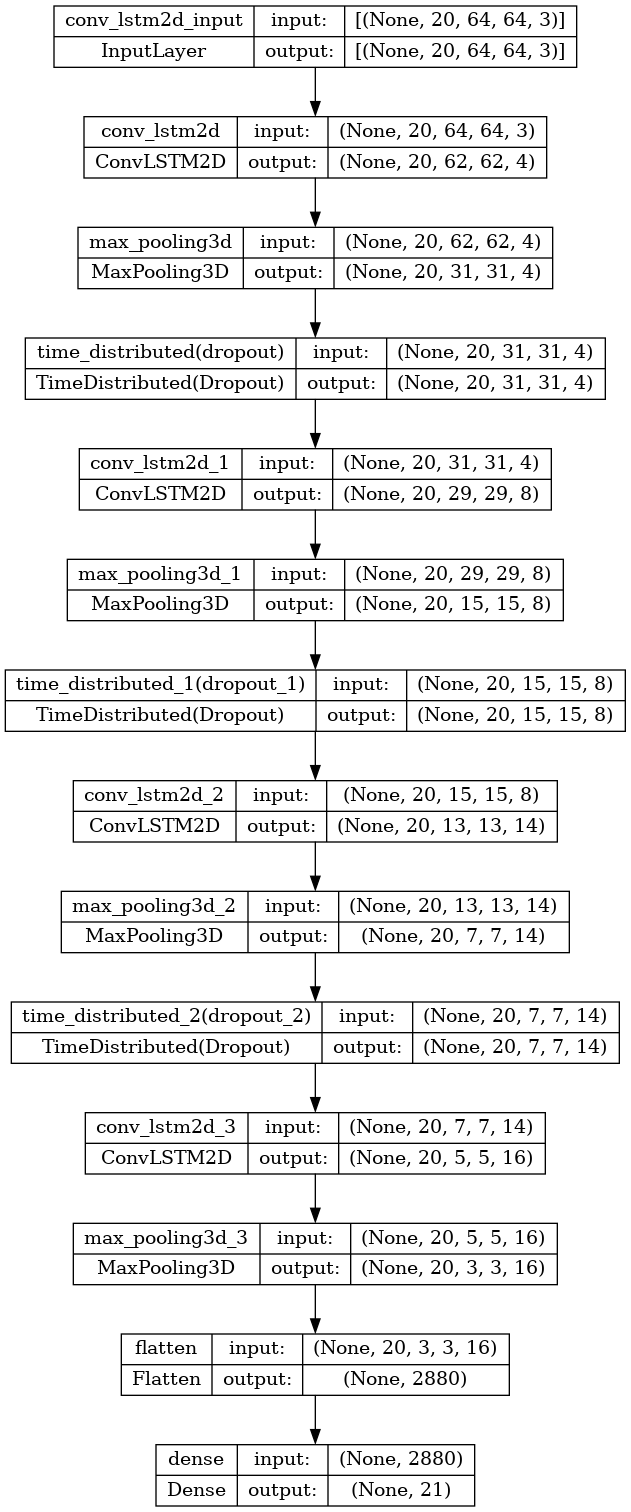

In [62]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Compile & Train the Model**

Next, we will add an early stopping callback to prevent overfitting and start the training after compiling the model.

In [63]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = features_train, y = label_train,
                                                     epochs = 5, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])


Epoch 1/5
607/607 [==============================] - 709s 1s/step - loss: 1.8324 - accuracy: 0.4671 - val_loss: 8.4826 - val_accuracy: 0.0000e+00
Epoch 2/5
607/607 [==============================] - 687s 1s/step - loss: 1.2046 - accuracy: 0.6215 - val_loss: 11.6193 - val_accuracy: 0.0066
Epoch 3/5
607/607 [==============================] - 686s 1s/step - loss: 0.8215 - accuracy: 0.7282 - val_loss: 16.3262 - val_accuracy: 0.0346
Epoch 4/5
607/607 [==============================] - 685s 1s/step - loss: 0.5603 - accuracy: 0.8237 - val_loss: 17.9644 - val_accuracy: 0.0412
Epoch 5/5
607/607 [==============================] - 686s 1s/step - loss: 0.4067 - accuracy: 0.8629 - val_loss: 18.8777 - val_accuracy: 0.0560


**Evaluate the Trained Model**

In [64]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(features_test, label_test)

39/39 [==============================] - 75s 2s/step - loss: 5.3969 - accuracy: 0.4911


**Save the Model**

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save your Model.
convlstm_model.save(model_file_name)

**Plot Model’s Loss & Accuracy Curves**

Now we will create a function plot_metric() to visualize the training and validation metrics. We already have separate metrics from our training and validation steps so now we just have to visualize them.

In [65]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

Now we will utilize the function plot_metric() created above, to visualize and understand the metrics.

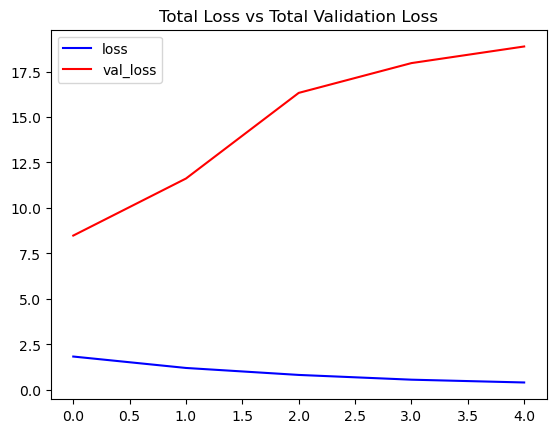

In [66]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

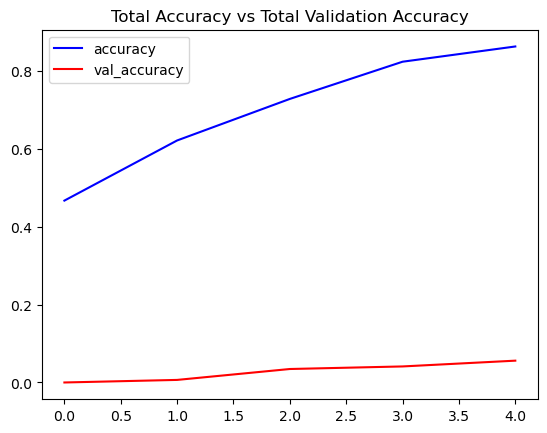

In [67]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# **Implement the LRCN Approach**

In this step, we will implement the LRCN Approach by combining Convolution and LSTM layers in a single model. Another similar approach can be to use a CNN model and LSTM model trained separately. The CNN model can be used to extract spatial features from the frames in the video, and for this purpose, a pre-trained model can be used, that can be fine-tuned for the problem. And the LSTM model can then use the features extracted by CNN, to predict the action being performed in the video.

But here, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

*You can read the paper Long-term Recurrent Convolutional Networks for Visual Recognition and Description by Jeff Donahue (CVPR 2015), to learn more about this architecture.
We will also use TimeDistributed wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape (no_of_frames, width, height, num_of_channels) if originally the layer’s input shape was (width, height, num_of_channels) which is very beneficial as it allows to input the whole video into the model in a single shot.*

**Construct the Model**

To implement our LRCN architecture, we will use time-distributed Conv2D layers which will be followed by MaxPooling2D and Dropout layers. The feature extracted from the Conv2D layers will be then flattened using the Flatten layer and will be fed to a LSTM layer. The Dense layer with softmax activation will then use the output from the LSTM layer to predict the action being performed.

In [68]:
def create_LRCN_model(): 
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''
 
    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))
 
    ########################################################################################################################
 
    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

Now we will utilize the function create_LRCN_model() created above to construct the required LRCN model.

In [69]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()
 
# Display the success message.
print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 20, 64, 64, 16)   448       
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 4, 4, 32)    

**Check Model’s Structure:**

Now we will use the plot_model() function to check the structure of the constructed LRCN model. As we had checked for the previous model.

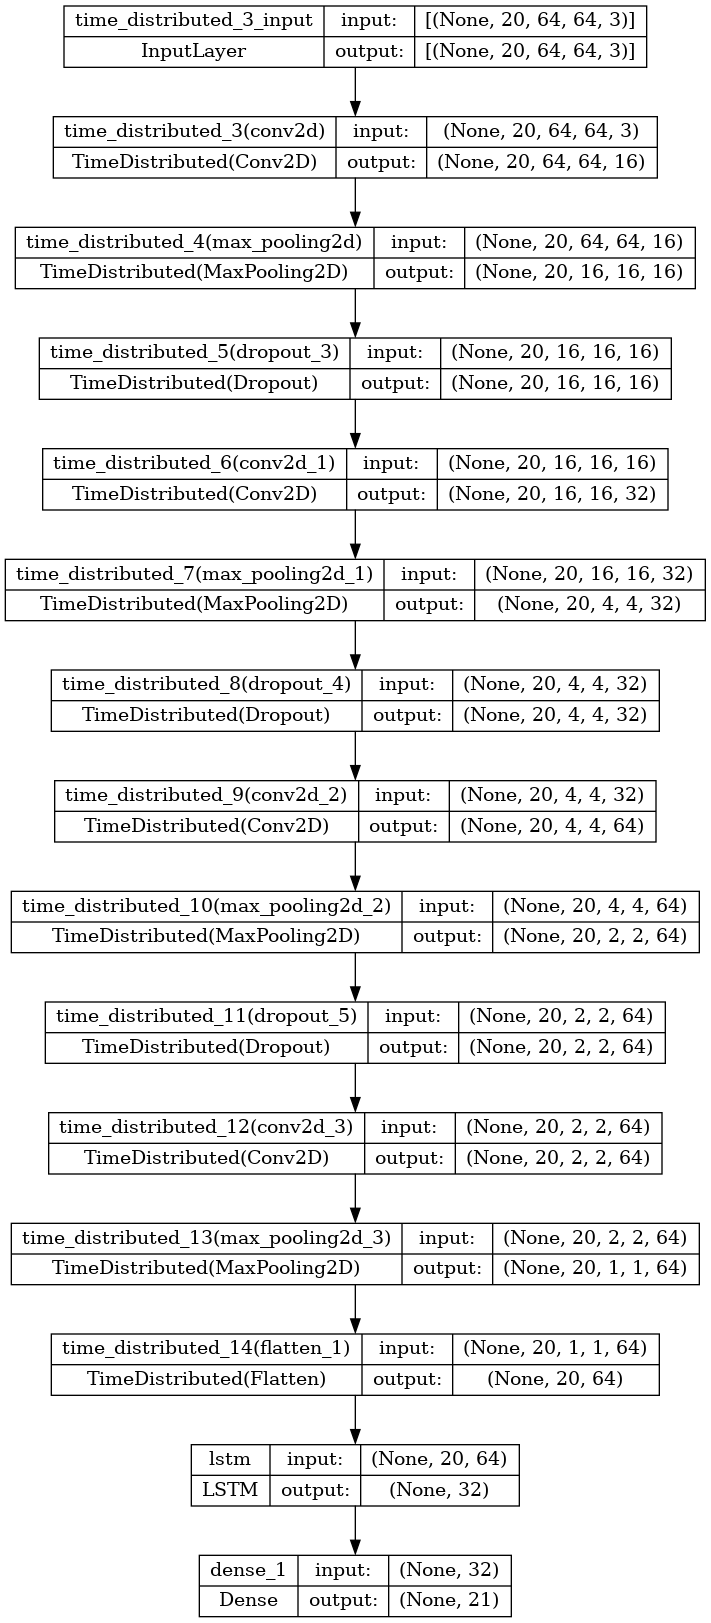

In [70]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Compile & Train the Model**

In [71]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = label_train, epochs = 5, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/5
607/607 [==============================] - 73s 116ms/step - loss: 2.2409 - accuracy: 0.3793 - val_loss: 6.6769 - val_accuracy: 0.0000e+00
Epoch 2/5
607/607 [==============================] - 66s 108ms/step - loss: 1.9036 - accuracy: 0.4329 - val_loss: 6.9862 - val_accuracy: 0.0000e+00
Epoch 3/5
607/607 [==============================] - 65s 108ms/step - loss: 1.7366 - accuracy: 0.4650 - val_loss: 7.3303 - val_accuracy: 0.0000e+00
Epoch 4/5
607/607 [==============================] - 66s 109ms/step - loss: 1.6035 - accuracy: 0.5074 - val_loss: 8.8207 - val_accuracy: 0.0000e+00
Epoch 5/5
607/607 [==============================] - 67s 110ms/step - loss: 1.4263 - accuracy: 0.5688 - val_loss: 9.4011 - val_accuracy: 0.0000e+00


**Evaluating the trained Model**

As done for the previous one, we will evaluate the LRCN model on the test set.

In [73]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, label_test)

39/39 [==============================] - 12s 304ms/step - loss: 3.0554 - accuracy: 0.4529


**Save the Model**

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
 
# Save the Model.
LRCN_model.save(model_file_name)

**Plot Model’s Loss & Accuracy Curves**

In [ ]:
#Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')